# Goal

* Conduct consenTRAIT analysis on all fullCyc traits
  * Traits:
    * incorporator (any day)
    * incorporator (any day/time)    
    * functional group (must do 1 cluster per 'trait')

# Setting variables

In [41]:
workDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/MW-HR-SIP/consenTRAIT/'

# 16S tree file of all representative OTU sequences
treeFile = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/fasttree/aln_for_tree_boot.nwk'
rootName = 'X90478'

# log2 fold change
#l2fcResDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/MW-HR-SIP/'
#l2fcResFile = 'l2fc_sparse-maxRejH.txt'
l2fcResDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/MW-HR-SIP/clust/classify/'
l2fcResFile  = 'l2fc_sparse-maxRejH_FuncG-clsM3a.txt'

# log2 fold change functional groups (FG)
#funcGroupDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/MW-HR-SIP/clust/'
#funcGroupFile = 'l2fc_sparse-maxRejH_FuncG.txt'

# params
padj_cutoff = 0.1 
nprocs = 14

# Init

In [42]:
import os
%load_ext rpy2.ipython
%load_ext pushnote

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The pushnote extension is already loaded. To reload it, use:
  %reload_ext pushnote


In [43]:
%%R
library(dplyr)
library(tidyr)
library(ggplot2)
library(ape)
library(caper)
library(gridExtra)

In [44]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
%cd $workDir

/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/MW-HR-SIP/consenTRAIT


In [45]:
%%R -i rootName
cat('variables loaded into R\n')

variables loaded into R


## Function for calculating D statistic

In [46]:
%%R
phylo.D = function (data, phy, names.col, binvar, permut = 1000, rnd.bias = NULL){
    # modified script from the from caper package
    if (!missing(data)) {
        if (!inherits(data, "comparative.data")) {
            if (missing(names.col)) 
                stop("names column is missing")
            names.col <- deparse(substitute(names.col))
            data <- caicStyleArgs(data = data, phy = phy, names.col = names.col)
        }
    }
   # binvar <- deparse(substitute(binvar))
    bininds <- match(binvar, names(data$data))
    if (is.na(bininds)) 
        (stop("'", binvar, "' is not a variable in data."))
    ds <- data$data[, bininds]
    if (any(is.na(ds))) 
        stop("'", binvar, "' contains missing values.")
    if (is.character(ds)) 
        ds <- as.factor(ds)
    if (length(unique(ds)) > 2) 
        stop("'", binvar, "' contains more than two states.")
    if (length(unique(ds)) < 2) 
        stop("'", binvar, "' only contains a single state.")
    propStates <- unclass(table(ds))
    propState1 <- propStates[1]/sum(propStates)
    names(dimnames(propStates)) <- binvar
    if (is.factor(ds)) 
        ds <- as.numeric(ds)
    if (!is.numeric(permut)) 
        (stop("'", permut, "' is not numeric."))
    if (!is.null(rnd.bias)) {
        rnd.bias <- deparse(substitute(rnd.bias))
        rnd.ind <- match(rnd.bias, names(data$data))
        if (is.na(rnd.ind)) 
            (stop("'", rnd.bias, "' is not a variable in data."))
        rnd.bias <- data$data[, rnd.bias]
    }
    el <- data$phy$edge.length
    elTip <- data$phy$edge[, 2] <= length(data$phy$tip.label)
    if (any(el[elTip] == 0)) 
        stop("Phylogeny contains pairs of tips on zero branch lengths, cannot currently simulate")
    if (any(el[!elTip] == 0)) 
        stop("Phylogeny contains zero length internal branches. Use di2multi.")
    ds.ran <- replicate(permut, sample(ds, prob = rnd.bias))
    if (is.null(data$vcv)) {
        vcv <- VCV.array(data$phy)
    }
    else {
        vcv <- data$vcv
    }
    ds.phy <- rmvnorm(permut, sigma = unclass(vcv))
    ds.phy <- as.data.frame(t(ds.phy))
    ds.phy.thresh <- apply(ds.phy, 2, quantile, propState1)
    ds.phy <- sweep(ds.phy, 2, ds.phy.thresh, "<")
    ds.phy <- as.numeric(ds.phy)
    dim(ds.phy) <- dim(ds.ran)
    ds.ran <- cbind(Obs = ds, ds.ran)
    ds.phy <- cbind(Obs = ds, ds.phy)
    dimnames(ds.ran) <- dimnames(ds.phy) <- list(data$phy$tip.label, 
        c("Obs", paste("V", 1:permut, sep = "")))
    phy <- reorder(data$phy, "pruningwise")
    ds.ran.cc <- contrCalc(vals = ds.ran, phy = phy, ref.var = "V1", 
        picMethod = "phylo.d", crunch.brlen = 0)
    ds.phy.cc <- contrCalc(vals = ds.phy, phy = phy, ref.var = "V1", 
        picMethod = "phylo.d", crunch.brlen = 0)
    ransocc <- colSums(ds.ran.cc$contrMat)
    physocc <- colSums(ds.phy.cc$contrMat)
    if (round(ransocc[1], digits = 6) != round(physocc[1], digits = 6)) 
        stop("Problem with character change calculation in phylo.d")
    obssocc <- ransocc[1]
    ransocc <- ransocc[-1]
    physocc <- physocc[-1]
    soccratio <- (obssocc - mean(physocc))/(mean(ransocc) - mean(physocc))
    soccpval1 <- sum(ransocc < obssocc)/permut
    soccpval0 <- sum(physocc > obssocc)/permut
    dvals <- list(DEstimate = soccratio, Pval1 = soccpval1, Pval0 = soccpval0, 
        Parameters = list(Observed = obssocc, MeanRandom = mean(ransocc), 
            MeanBrownian = mean(physocc)), StatesTable = propStates, 
        Permutations = list(random = ransocc, brownian = physocc), 
        NodalVals = list(observed = ds.ran.cc$nodVals[, 1, drop = FALSE], 
            random = ds.ran.cc$nodVals[, -1, drop = FALSE], brownian = ds.phy.cc$nodVals[, 
                -1, drop = FALSE]), binvar = binvar, data = data, 
        nPermut = permut, rnd.bias = rnd.bias)
    class(dvals) <- "phylo.d"
    return(dvals)
}
        
phylo.d.multi = function(df, phy){
    # works much like multiPhylosignal (same inputs)
    traits = colnames(df)
    df.comp = df
    df.comp$OTU = rownames(df.comp)
    df.comp = comparative.data(phy, df.comp, names.col='OTU')
    ret = sapply(traits, function(x) phylo.D(df.comp, binvar=x))
    ret = apply(ret[1:3,] %>% t, 2, unlist)
    ret = ret %>% as.data.frame
    ret$Trait = traits
    return(ret)
}

# example
#D = phylo.d.multi(df.byFG[,1:2], tree.p)
#D         

# Setting up trait files

In [47]:
%%R -i l2fcResDir -i l2fcResFile 

F = file.path(l2fcResDir, l2fcResFile)

df.l2fc = read.delim(F, sep='\t') %>%
    mutate(Rank2 = gsub('^__', '', Rank2),
           Rank3 = gsub('^__', '', Rank3),
           Rank4 = gsub('^__', '', Rank4),
           Rank5 = gsub('^__', '', Rank5),
           Rank6 = gsub('^__', '', Rank6),
           Rank7 = gsub('^__', '', Rank7))
df.l2fc %>% head(n=3)

  Substrate Day Microcosm_replicate      OTU log2FoldChange         p padj
1   13C-Cel   3                   1 OTU.1386      0.7583977 0.2726321    1
2   13C-Cel   3                   1  OTU.729      0.9666338 0.1595477    1
3   13C-Cel   3                   1 OTU.7877      0.4506700 0.4046957    1
     Rank1         Rank2      Rank3                              Rank4 Rank5
1 Bacteria Acidobacteria       RB25               uncultured_bacterium  <NA>
2 Bacteria Acidobacteria       RB25 uncultured_Acidobacteria_bacterium  <NA>
3 Bacteria Acidobacteria Holophagae                          43F-1404R  <NA>
  Rank6 Rank7 Rank8 density_min density_max sparsity_threshold Incorporator
1  <NA>  <NA>  <NA>         1.7        1.73               0.05            0
2  <NA>  <NA>  <NA>         1.7        1.73               0.05            0
3  <NA>  <NA>  <NA>         1.7        1.73               0.05            0
  func_group               func_group_cls
1         13 DOC:Early,POC:Early,Van:Late
2   

## Incorporator at any time point

In [48]:
%%R -i padj_cutoff -i rootName

# matrix of incorporators
df.inc = df.l2fc %>%
    filter(padj < padj_cutoff) %>%    
    distinct(OTU, Substrate) %>%
    dplyr::select(OTU, Substrate) %>%
    mutate(X = 1) %>%
    spread(Substrate, X, fill=0)

# adding root
df.inc$OTU = df.inc$OTU %>% as.vector
rootrow = c(rootName, rep(0, ncol(df.inc)-1))
df.inc = rbind(df.inc, rootrow)

# writing table
write.table(df.inc, 'incorp_trait_bySub.txt', sep='\t', quote=FALSE, row.names=FALSE, col.names=FALSE)
cat('Total number of incorporator OTUs:', df.inc$OTU %>% unique %>% length, '\n\n')
df.inc %>% tail(n=3)

Total number of incorporator OTUs: 1287 

          OTU 13C-Ami 13C-Cel 13C-Glu 13C-Gly 13C-Lac 13C-Oxa 13C-Pal 13C-Van
1285  OTU.997       0       0       0       0       1       1       0       0
1286 OTU.9982       1       0       1       0       0       1       0       0
1287   X90478       0       0       0       0       0       0       0       0
     13C-Xyl
1285       0
1286       0
1287       0


In [49]:
!head -n 3 incorp_trait_bySub.txt

OTU.1	0	0	0	0	0	1	1	1	1
OTU.10	0	1	1	0	1	0	0	1	1
OTU.100	0	1	0	0	0	0	0	0	0


## Incorporator for any day/time

In [50]:
%%R -i padj_cutoff -i rootName

# matrix of incorporators
df.inc = df.l2fc %>%
    filter(padj < padj_cutoff) %>%    
    distinct(OTU, Substrate, Day) %>%
    dplyr::select(OTU, Substrate, Day) %>%
    mutate(Day = gsub('^', 'D', Day)) %>%
    unite('Sub_Day', Substrate, Day, sep='_') %>%
    mutate(X = 1) %>%
    spread(Sub_Day, X, fill=0)

# adding root
df.inc$OTU = df.inc$OTU %>% as.vector
rootrow = c(rootName, rep(0, ncol(df.inc)-1))
df.inc = rbind(df.inc, rootrow)

write.table(df.inc, 'incorp_trait_bySubDay.txt', sep='\t', quote=FALSE, row.names=FALSE, col.names=FALSE)
cat('Total number of incorporator OTUs:', df.inc$OTU %>% unique %>% length, '\n\n')
df.inc %>% tail(n=3)

Total number of incorporator OTUs: 1287 

          OTU 13C-Ami_D1 13C-Ami_D14 13C-Ami_D3 13C-Ami_D6 13C-Cel_D14
1285  OTU.997          0           0          0          0           0
1286 OTU.9982          0           1          0          0           0
1287   X90478          0           0          0          0           0
     13C-Cel_D3 13C-Cel_D30 13C-Cel_D48 13C-Cel_D6 13C-Glu_D1 13C-Glu_D14
1285          0           0           0          0          0           0
1286          0           0           0          0          0           1
1287          0           0           0          0          0           0
     13C-Glu_D3 13C-Glu_D6 13C-Gly_D1 13C-Gly_D14 13C-Gly_D3 13C-Gly_D6
1285          0          0          0           0          0          0
1286          0          0          0           0          0          0
1287          0          0          0           0          0          0
     13C-Lac_D1 13C-Lac_D3 13C-Lac_D6 13C-Oxa_D14 13C-Oxa_D3 13C-Oxa_D6
1285          0   

In [51]:
!head -n 3 incorp_trait_bySubDay.txt

OTU.1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	1	0	0	1	0	0	0	1	1	1
OTU.10	0	0	0	0	0	0	0	1	0	0	1	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	1	0	0	1	0	1
OTU.100	0	0	0	0	0	0	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0


## Functional group clusters

In [53]:
%%R -i padj_cutoff -i rootName

# matrix of incorporators
df.FG = df.l2fc %>%
    filter(padj < padj_cutoff) %>%    
    distinct(OTU, func_group) %>%
    dplyr::select(OTU, func_group) %>%
    mutate(X = 1) %>%
    spread(func_group, X, fill=0)

# adding root
df.FG$OTU = df.FG$OTU %>% as.vector
rootrow = c(rootName, rep(0, ncol(df.FG)-1))
df.FG = rbind(df.FG, rootrow)

# writing
write.table(df.FG, 'incorp_trait_funcG.txt', sep='\t', quote=FALSE, row.names=FALSE, col.names=FALSE)
cat('Number of clusters: ', ncol(df.FG)-1, '\n')
cat('Number of OTUs: ', nrow(df.FG), '\n\n')
df.FG %>% tail(n=3)

Number of clusters:  26 
Number of OTUs:  1287 

          OTU 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
1285  OTU.997 0 0 0 0 0 0 1 0 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
1286 OTU.9982 0 0 0 0 0 0 0 0 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
1287   X90478 0 0 0 0 0 0 0 0 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     26
1285  0
1286  0
1287  0


In [54]:
!head -n 3 incorp_trait_funcG.txt

OTU.1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0
OTU.10	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
OTU.100	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0


## Functional group classifications

In [55]:
%%R -i padj_cutoff -i rootName

# matrix of incorporators
df.FGC = df.l2fc %>%
    filter(padj < padj_cutoff) %>%    
    distinct(OTU, func_group_cls) %>%
    dplyr::select(OTU, func_group_cls) %>%
    mutate(X = 1) %>%
    spread(func_group_cls, X, fill=0)

# adding root
df.FGC$OTU = df.FGC$OTU %>% as.vector
rootrow = c(rootName, rep(0, ncol(df.FGC)-1))
df.FGC = rbind(df.FGC, rootrow)

# writing
write.table(df.FGC, 'incorp_trait_funcGC.txt', sep='\t', quote=FALSE, row.names=FALSE, col.names=FALSE)
cat('Number of clusters: ', ncol(df.FGC)-1, '\n')
cat('Number of OTUs: ', nrow(df.FGC), '\n\n')
df.FGC %>% tail(n=3)

Number of clusters:  15 
Number of OTUs:  1287 

          OTU DOC:Early DOC:Early,POC:Early DOC:Early,POC:Early,Van:Late
1285  OTU.997         0                   0                            0
1286 OTU.9982         0                   0                            0
1287   X90478         0                   0                            0
     DOC:Early,POC:Late DOC:Early,POC:Late,Van:Early
1285                  0                            0
1286                  0                            0
1287                  0                            0
     DOC:Early,POC:Late,Van:Late DOC:Late DOC:Late,POC:Early
1285                           0        1                  0
1286                           0        0                  0
1287                           0        0                  0
     DOC:Late,POC:Early,Van:Early DOC:Late,POC:Early,Van:Late DOC:Late,POC:Late
1285                            0                           0                 0
1286                            1          

In [56]:
!head -n 3 incorp_trait_funcGC.txt

OTU.1	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0
OTU.10	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0
OTU.100	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0


# Pruning bootstrap trees

##  Just incoporators

In [17]:
%%R -i treeFile -i workDir -i rootName
# loading in trees
trees = read.tree(treeFile)
trees

100 phylogenetic trees


In [18]:
%%R
# pruning
pruneTree = function(tree, taxa){
    # not matching OTUs
    to.rm = setdiff(tree$tip, taxa)
    # pruning
    tree = drop.tip(tree, to.rm)    
    # rooting
    tree = multi2di(tree)
    tree = root(tree, rootName)
    # returning
    return(tree)
    }

trees.p = lapply(trees, pruneTree, taxa=df.inc$OTU)
class(trees.p) = 'multiPhylo'
trees.p

100 phylogenetic trees


In [19]:
%%R
# writing pruned tree
tree.out = file.path(workDir, 'otusn_pick_incorps.nwk')
write.tree(trees.p, tree.out)
cat('File written:', tree.out, '\n')

# clearing memory
trees = trees.p = NULL

File written: /var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/MW-HR-SIP/consenTRAIT//otusn_pick_incorps.nwk 


# Check: mapping traits onto tree

In [20]:
%%R
# loading tree
real.tree = read.tree('/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/fasttree/otusn_pick_lad.nwk')

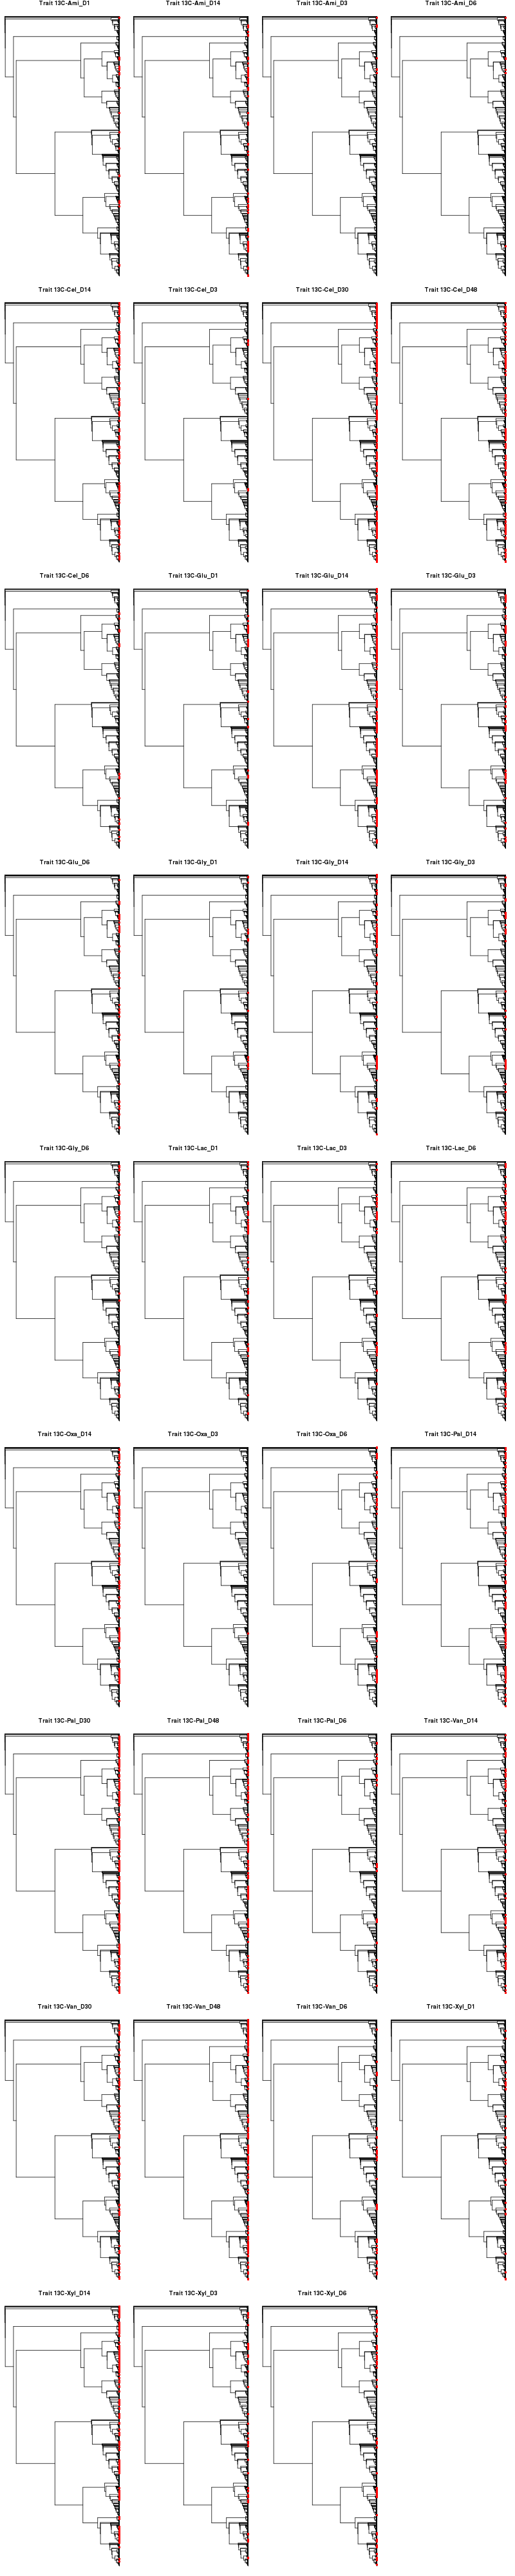

In [21]:
%%R -h 4000 -w 800

# function for plotting tree with traits
map_trait = function(trait_ID, phy, traits){
    # selecting a trait
    my.cols = traits[phy$tip,trait_ID]  
    my.tips = which(my.cols > 0)
    my.cols = my.cols[my.cols > 0]
    my.cols = 'red'
    
    # plotting
    title = paste0('Trait ', trait_ID)
    plot(phy, show.tip.label=FALSE, main=title, use.edge.length=FALSE, adj=1)
    tiplabels(tip=my.tips, pch=22, col=NULL, bg=my.cols, cex=1)
    
    return(0)
    }

# traits
df.inc.e = df.inc 
rownames(df.inc.e) = df.inc.e$OTU
df.inc.e$OTU = NULL

# plotting dimensions
ncolumns = 4
nrows = ceiling((df.inc.e %>% ncol) / ncolumns)
par(mfrow=c(nrows, ncolumns),
    mar=c(0,0,1,0))

# making trees
#my.tree = trees[[1]] %>% ladderize
#plot(my.tree)
my.traits = df.inc.e %>% colnames
ret = sapply(my.traits, map_trait, phy=real.tree, traits=df.inc.e)

In [22]:
%%R -h 4000 -w 800

# # traits
# df.FG.e = df.FG 
# rownames(df.FG.e) = df.FG.e$OTU
# df.FG.e$OTU = NULL

# # plotting dimensions
# ncolumns = 4
# nrows = ceiling((df.FG.e %>% ncol) / ncolumns)
# par(mfrow=c(nrows, ncolumns),
#     mar=c(0,0,1,0))

# # making trees
# #my.tree = trees[[1]] %>% ladderize
# my.traits = df.FG.e %>% colnames
# ret = sapply(my.traits, map_trait, phy=real.tree, traits=df.FG.e)

NULL


# Calling consenTRAIT

## Incorporator: any day

In [ ]:
!/home/nick/dev/consenTRAIT/consenTRAIT.r \
    -p $nprocs \
    otusn_pick_incorps.nwk \
    $rootName \
    incorp_trait_bySub.txt \
    > incorp_trait_bySub_tauD.txt

Analyzing tree:  1 
  Analyzing trait:  1 
  Analyzing trait:  2 
  Analyzing trait:  3 
  Analyzing trait:  4 
  Analyzing trait:  5 
  Analyzing trait:  6 
  Analyzing trait:  7 
  Analyzing trait:  8 
  Analyzing trait:  9 
Analyzing tree:  2 
  Analyzing trait:  1 
  Analyzing trait:  2 
  Analyzing trait:  3 
  Analyzing trait:  4 
  Analyzing trait:  5 
  Analyzing trait:  6 
  Analyzing trait:  7 
  Analyzing trait:  8 
  Analyzing trait:  9 
Analyzing tree:  3 
  Analyzing trait:  1 
  Analyzing trait:  2 
  Analyzing trait:  3 
  Analyzing trait:  4 
  Analyzing trait:  5 
  Analyzing trait:  6 
  Analyzing trait:  7 
  Analyzing trait:  8 
  Analyzing trait:  9 
Analyzing tree:  4 
  Analyzing trait:  1 
  Analyzing trait:  2 
  Analyzing trait:  3 
  Analyzing trait:  4 
  Analyzing trait:  5 
  Analyzing trait:  6 
  Analyzing trait:  7 
  Analyzing trait:  8 
  Analyzing trait:  9 
Analyzing tree:  5 
  Analyzing trait:  1 
  Analyzing trait:  2 
  Analyzing trait:  3 
  A

In [34]:
%%R
# functions for calling significance
p.cut_OLD = function(p, n_lev=2){
    if(p < 0.01){
        return('<0.01')
    } else
    if (n_lev == 2){
        return('≥0.01')        
    } else 
    if (n_lev == 3){
        if(p < 0.05){
            return('<0.05')
    } else{
        return('≥0.05')
        }
    } else {
        stop('n_lev must be 2 or 3')
    }
}
   

p.cut = function(p){
    if(p < 0.05){
        return('<0.05')
    } else
    if (p >= 0.05){
        return('≥0.05')        
    } else {
        return(NA)
    }
}

In [133]:
%%R
# loading results
df.CT.sub = read.delim('incorp_trait_bySub_tauD.txt', sep='\t')
df.CT.sub$Substrate = df.l2fc$Substrate %>% levels


df.CT.sub = df.CT.sub  %>%
    mutate(p.value = p.adjust(p.value, method='BH'),
           p.value.id = sapply(p.value, p.cut))

df.CT.sub 

  Trait      tau_D   p.value Substrate p.value.id
1    t1 0.01105993 0.0000000   13C-Ami      <0.05
2    t2 0.02051219 0.7585714   13C-Cel      ≥0.05
3    t3 0.01450248 0.0000000   13C-Glu      <0.05
4    t4 0.01128889 0.0000000   13C-Gly      <0.05
5    t5 0.01289351 0.0000000   13C-Lac      <0.05
6    t6 0.01196239 0.0000000   13C-Oxa      <0.05
7    t7 0.02460140 0.9400000   13C-Pal      ≥0.05
8    t8 0.02253286 0.8775000   13C-Van      ≥0.05
9    t9 0.01408440 0.0000000   13C-Xyl      <0.05


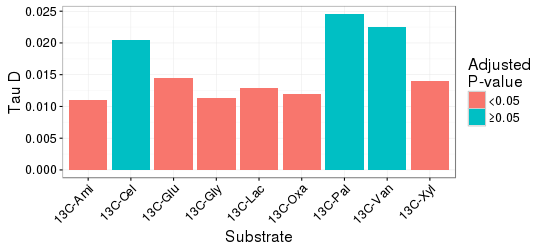

In [134]:
%%R -w 550 -h 250

p.sub = ggplot(df.CT.sub, aes(Substrate, tau_D, fill=p.value.id)) +
    geom_bar(stat='identity') +
   # geom_point(data=df.CT.sub %>% filter(p.value.id != '>0.05'),
   #            aes(y=tau_D + 0.001, color=p.value.id), size=3) +
    scale_fill_discrete('Adjusted\nP-value') +
    labs(y='Tau D') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )
p.sub

## Incorporator: by substrate/day

In [ ]:
!/home/nick/dev/consenTRAIT/consenTRAIT.r \
    -p $nprocs \
    -c cluster_size_bySubDay \
    -d cluster_dist_bySubDay \
    -t Tau_D_bySubDay \
    -u Tau_D_boot_bySubDay \
    otusn_pick_incorps.nwk \
    $rootName \
    incorp_trait_bySubDay.txt \
    2> incorp_trait_bySubDay_tauD.log \
    > incorp_trait_bySubDay_tauD.txt

In [135]:
%%R
# loading results
df.CT.subday = read.delim('incorp_trait_bySubDay_tauD.txt', sep='\t')

df.CT.subday$Substrate_Day = colnames(df.inc)[2:ncol(df.inc)]
df.CT.subday = df.CT.subday  %>%
    separate(Substrate_Day, c('Substrate', 'Day'), sep='_') %>%
    mutate(Day = gsub('^D', '', Day),
           p.value = p.adjust(p.value, method='BH'),
           p.value.id = sapply(p.value, p.cut))
    
df.CT.subday$Day = reorder(df.CT.subday$Day, df.CT.subday$Day %>% as.numeric)
    
df.CT.subday 

   Trait       tau_D    p.value Substrate Day p.value.id
1     t1 0.009765008 0.00000000   13C-Ami   1      <0.05
2     t2 0.011499244 0.00000000   13C-Ami  14      <0.05
3     t3 0.004097286 0.00000000   13C-Ami   3      <0.05
4     t4 0.001990300 0.00000000   13C-Ami   6      <0.05
5     t5 0.019202714 0.15312500   13C-Cel  14      ≥0.05
6     t6 0.006235600 0.00000000   13C-Cel   3      <0.05
7     t7 0.015363179 0.00000000   13C-Cel  30      <0.05
8     t8 0.021615756 0.64696970   13C-Cel  48      ≥0.05
9     t9 0.008556528 0.00000000   13C-Cel   6      <0.05
10   t10 0.010876411 0.00000000   13C-Glu   1      <0.05
11   t11 0.014026560 0.00000000   13C-Glu  14      <0.05
12   t12 0.008413330 0.00000000   13C-Glu   3      <0.05
13   t13 0.010527412 0.00000000   13C-Glu   6      <0.05
14   t14 0.007827776 0.00000000   13C-Gly   1      <0.05
15   t15 0.011756909 0.00000000   13C-Gly  14      <0.05
16   t16 0.009483220 0.00000000   13C-Gly   3      <0.05
17   t17 0.009582521 0.00000000

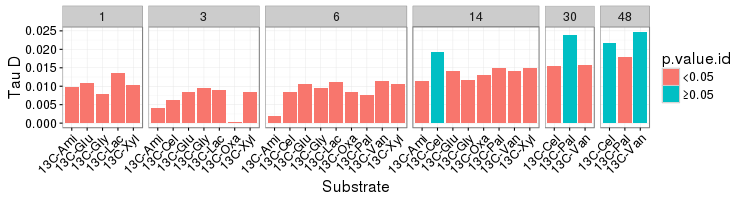

In [136]:
%%R -w 750 -h 200

p.subDay = ggplot(df.CT.subday, aes(Substrate, tau_D, fill=p.value.id)) +
    geom_bar(stat='identity') +
    scale_color_discrete('Significant\nP-value') +
    labs(y='Tau D') +
    facet_grid(. ~ Day, scales='free_x', space='free_x') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

p.subDay

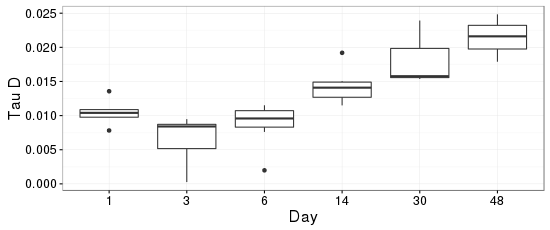

In [137]:
%%R -h 230 -w 550
# plotting phylogenetic diversity of each tree

# plotting
ggplot(df.CT.subday, aes(Day, tau_D)) +
    geom_boxplot() +
    labs(y='Tau D') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [138]:
%%R
# normally distributed?
shapiro.test(df.CT.subday$tau_D)


	Shapiro-Wilk normality test

data:  df.CT.subday$tau_D
W = 0.96062, p-value = 0.2387



In [183]:
%%R
as.Num = function(x) x %>% as.character %>% as.numeric
    
df.CT.subday.e = df.CT.subday %>%
    mutate(Day = Day %>% as.Num,
           p.value.id = gsub('≥', '>=', p.value.id),
           X = 1)
lm.res = lm(tau_D ~ Day, df.CT.subday.e) 
lm.res %>% summary   


Call:
lm(formula = tau_D ~ Day, data = df.CT.subday.e)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0086219 -0.0014161  0.0001081  0.0017662  0.0068792 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 7.953e-03  7.648e-04  10.398 6.04e-12 ***
Day         3.122e-04  4.206e-05   7.422 1.58e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.003362 on 33 degrees of freedom
Multiple R-squared:  0.6254,	Adjusted R-squared:  0.614 
F-statistic: 55.08 on 1 and 33 DF,  p-value: 1.581e-08



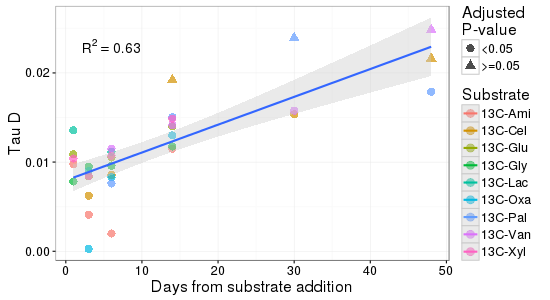

In [184]:
%%R -w 550 -h 300

p.lm = ggplot(df.CT.subday.e, aes(Day, tau_D, color=Substrate, group=X, shape=p.value.id)) +
    geom_point(size=3.5, alpha=0.7) +
    geom_smooth(method='lm', fill='grey80') +
    annotate('text', label='R^2 == 0.63', x=6, y=0.023, size=5, parse=TRUE) +
    scale_shape_discrete('Adjusted\nP-value') +
    labs(x='Days from substrate addition', y='Tau D') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.lm

In [185]:
%%R -i workDir
outFile = 'FG_bySubDay_tauD_lm.pdf'
ggsave(outFile, p.lm, width=8, height=4.3)
cat('File written:', file.path(workDir, outFile), '\n')

File written: /var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/MW-HR-SIP/consenTRAIT//FG_bySubDay_tauD_lm.pdf 


In [141]:
%%R
as.Num = function(x) x %>% as.character %>% as.numeric
# increase in tau_D with time?
cor.test(df.CT.subday$Day %>% as.Num, df.CT.subday$tau_D, method='pearson') %>% print
cat('--------\n')
cor.test(df.CT.subday$Day %>% as.Num, df.CT.subday$tau_D, method='spearman') %>% print


	Pearson's product-moment correlation

data:  df.CT.subday$Day %>% as.Num and df.CT.subday$tau_D
t = 7.4218, df = 33, p-value = 1.581e-08
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6212712 0.8896041
sample estimates:
      cor 
0.7907944 

--------

	Spearman's rank correlation rho

data:  df.CT.subday$Day %>% as.Num and df.CT.subday$tau_D
S = 1794.1, p-value = 2.307e-07
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.7487292 



## Functional groups

In [ ]:
!/home/nick/dev/consenTRAIT/consenTRAIT.r \
    -p $nprocs \
    -c cluster_size_funcG \
    -d cluster_dist_funcG \
    -t Tau_D_funcG \
    -u Tau_D_boot_funcG \
    otusn_pick_incorps.nwk \
    $rootName \
    incorp_trait_funcG.txt \
    2> incorp_trait_funcG_tauD.log \
    > incorp_trait_funcG_tauD.txt

In [57]:
%%R
# reading in data
df.CT.FG = read.delim('incorp_trait_funcG_tauD.txt', sep='\t')

df.CT.FG$func_group = colnames(df.FG)[2:ncol(df.FG)]
df.CT.FG = df.CT.FG  %>%
    mutate(func_group = gsub('FG', '', func_group),
           func_group = func_group %>% as.numeric,
           p.value = p.adjust(p.value, method='BH'),
           p.value.id = sapply(p.value, p.cut))
        
df.CT.FG

   Trait       tau_D    p.value func_group p.value.id
1     t1 0.017119108 0.00000000          1      <0.05
2     t2 0.012417976 0.00000000          2      <0.05
3     t3 0.014688535 0.00000000          3      <0.05
4     t4 0.017743442 0.01857143          4      <0.05
5     t5 0.010733084 0.00000000          5      <0.05
6     t6 0.030590968 1.00000000          6      ≥0.05
7     t7 0.018094679 0.01857143          7      <0.05
8     t8 0.014861583 0.00000000          8      <0.05
9     t9 0.029665059 1.00000000          9      ≥0.05
10   t10 0.011460600 0.00000000         10      <0.05
11   t11 0.021139067 0.93294118         11      ≥0.05
12   t12 0.023004155 1.00000000         12      ≥0.05
13   t13 0.020956434 0.93294118         13      ≥0.05
14   t14 0.025988106 1.00000000         14      ≥0.05
15   t15 0.018649727 0.38133333         15      ≥0.05
16   t16 0.013750431 0.00000000         16      <0.05
17   t17 0.027978088 1.00000000         17      ≥0.05
18   t18 0.023083582 1.00000

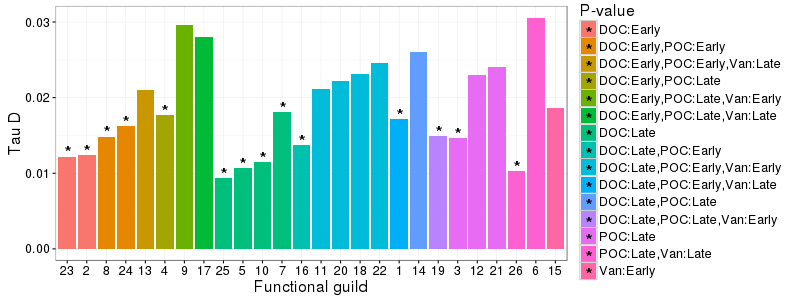

In [58]:
%%R -w 800 -h 300
as.Num = function(x) x %>% as.character %>% as.numeric

df.CT.FG.j = inner_join(df.CT.FG,
                   df.l2fc %>% 
                        dplyr::select(func_group, func_group_cls) %>%
                       distinct(func_group, func_group_cls),
                   c('func_group'='func_group')) %>%
    mutate(func_group = func_group %>% as.Num,
           func_group = func_group %>% reorder(tau_D), 
           func_group = func_group %>% reorder(func_group_cls %>% as.factor %>% as.numeric))

# plotting
p.FG = ggplot(df.CT.FG.j, aes(func_group, tau_D, fill=func_group_cls)) +
    geom_bar(stat='identity') +
    geom_point(data=df.CT.FG.j %>% filter(p.value.id == '<0.05'),
               aes(y=tau_D + 0.001), size=6, shape='*') +
    scale_fill_discrete('Adjusted\nP-value') +
    labs(x='Functional guild', y='Tau D') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        strip.background = element_blank(),
        strip.text = element_blank()
    )
p.FG

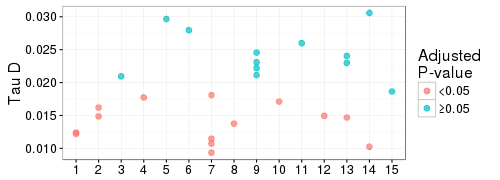

In [72]:
%%R -w 500 -h 180
df.CT.FG.j.e = df.CT.FG.j %>%
    mutate(func_group_cls_num = func_group_cls %>% as.factor %>% as.numeric %>% as.character,
           func_group_cls_num = func_group_cls_num %>% reorder(func_group_cls %>% as.factor %>% as.numeric))


p.FG.pnt = ggplot(df.CT.FG.j.e, aes(func_group_cls_num, tau_D)) +
    geom_point(aes(color=p.value.id), size=2.5, alpha=0.7) +
    scale_color_discrete('Adjusted\nP-value') +
    labs(x='Functional guild', y='Tau D') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank()
    )
p.FG.pnt

In [73]:
%%R
# signficant clusters
df.CT.FG %>%
    filter(p.value.id %in% c('<0.05'))

   Trait       tau_D    p.value func_group p.value.id
1     t1 0.017119108 0.00000000          1      <0.05
2     t2 0.012417976 0.00000000          2      <0.05
3     t3 0.014688535 0.00000000          3      <0.05
4     t4 0.017743442 0.01857143          4      <0.05
5     t5 0.010733084 0.00000000          5      <0.05
6     t7 0.018094679 0.01857143          7      <0.05
7     t8 0.014861583 0.00000000          8      <0.05
8    t10 0.011460600 0.00000000         10      <0.05
9    t16 0.013750431 0.00000000         16      <0.05
10   t19 0.014947427 0.00000000         19      <0.05
11   t23 0.012212230 0.00000000         23      <0.05
12   t24 0.016199054 0.00000000         24      <0.05
13   t25 0.009346739 0.00000000         25      <0.05
14   t26 0.010246970 0.00000000         26      <0.05


# Making a combined figure

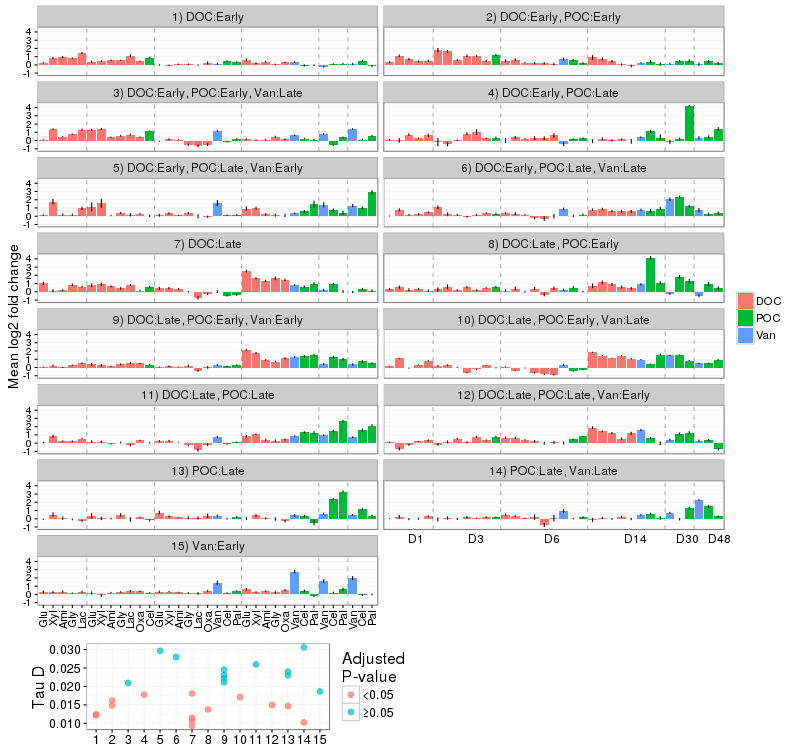

In [75]:
%%R -w 800 -h 750
# classification example figure
F = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/MW-HR-SIP/clust/classify//FG-clsfy-M3a_exmpl'
p.FGC = readRDS(F)

cowplot::ggdraw() +
    geom_rect(aes(xmin=0, ymin=0, xmax=1, ymax=1), fill='white') +
    cowplot::draw_plot(p.FGC, 0, 0.15, 1, 0.85) +
    cowplot::draw_plot(p.FG.pnt, 0.03, 0, 0.5, 0.15)

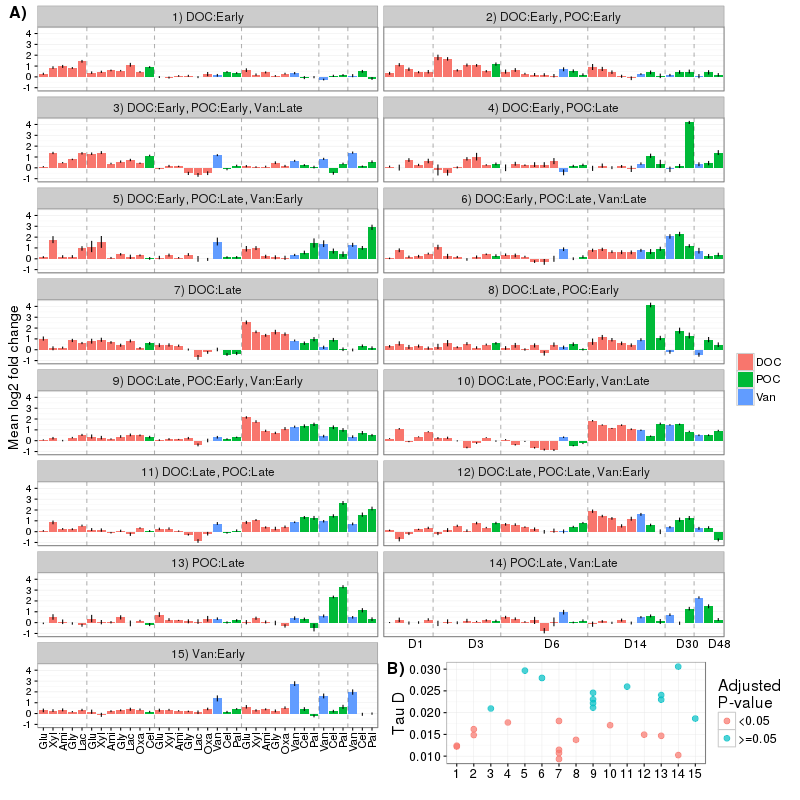

In [131]:
%%R -w 800 -h 800
# classification example figure
F = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/MW-HR-SIP/clust/classify//FG-clsfy-M3a_exmpl'
p.FGC = readRDS(F)

x = expression(phantom(x)>=0.05)

p.FG.pnt.f = p.FG.pnt +
    scale_color_discrete('Adjusted\nP-value', labels=c('<0.05', '>=0.05')) +
    theme(
        plot.background = element_rect(fill='transparent')
    )

p.comb = cowplot::ggdraw() +
    geom_rect(aes(xmin=0, ymin=0, xmax=1, ymax=1), fill='white') +
    cowplot::draw_plot(p.FGC, 0, 0.05, 1, 0.95) +
    cowplot::draw_plot(p.FG.pnt.f, 0.48, 0.02, 0.52, 0.16) +
    #geom_rect(aes(xmin=0.48, ymin=0.01, xmax=0.96, ymax=0.17), fill='transparent', color='black', size=0.2) +
    cowplot::draw_plot_label(c('A)', 'B)'), c(0, 0.473), c(1, 0.18))
p.comb

In [132]:
%%R -w 800 -h 750
# classification example figure
F = file.path(workDir, 'FG-clsfy-M3a_exmpl_wTauD.pdf')
cowplot::ggsave(F, p.comb, width=12, height=11)
cat('File written:', F, '\n')

File written: /var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/MW-HR-SIP/consenTRAIT//FG-clsfy-M3a_exmpl_wTauD.pdf 


#### With taxonomy

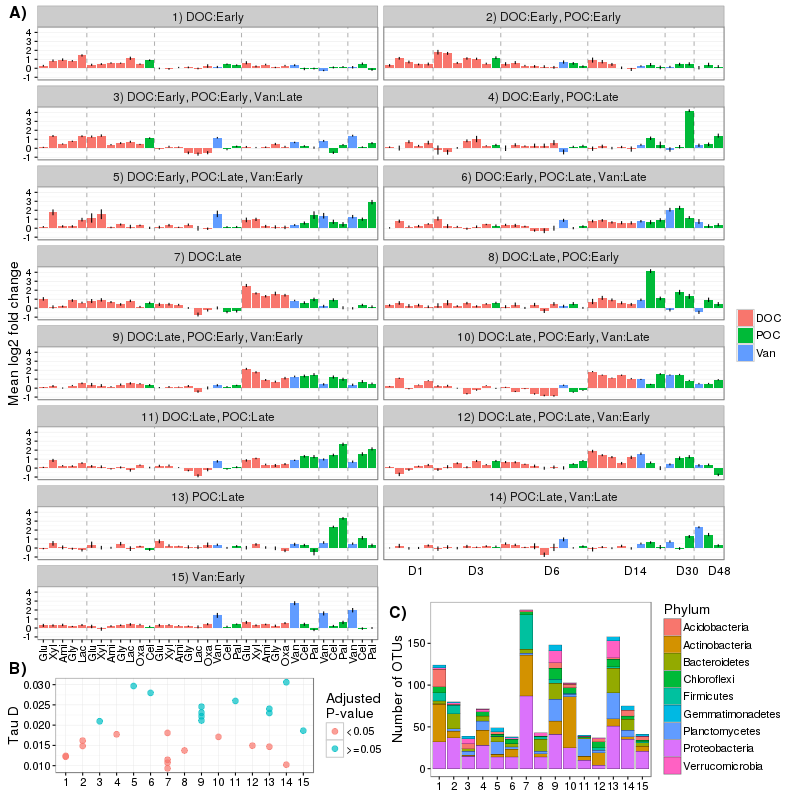

In [156]:
%%R -w 800 -h 800
# classification example figure
F = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/MW-HR-SIP/clust/classify//FG-clsfy-M3a_exmpl'
p.FGC = readRDS(F)

# classification taxonomy
F = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/MW-HR-SIP/clust/classify//FG-clsfy-M3a_phylum'
p.FGC.phy = readRDS(F)

x = expression(phantom(x)>=0.05)

p.FG.pnt.f = p.FG.pnt +
    scale_color_discrete('Adjusted\nP-value', labels=c('<0.05', '>=0.05')) +
    theme(
        text = element_text(size=14),
        plot.background = element_rect(fill='transparent')
    )

p.FGC.phy.f = p.FGC.phy +
    scale_x_discrete(labels=1:15) +
    theme(
        text = element_text(size=14),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=0, hjust=0.5),
        plot.background = element_rect(fill='transparent')
    )

p.comb = cowplot::ggdraw() +
    geom_rect(aes(xmin=0, ymin=0, xmax=1, ymax=1), fill='white') +
    cowplot::draw_plot(p.FGC, 0, 0.16, 1, 0.84) +
    cowplot::draw_plot(p.FG.pnt.f, 0, 0.01, 0.5, 0.15) +
    cowplot::draw_plot(p.FGC.phy.f, 0.48, 0.005, 0.52, 0.25) +
    cowplot::draw_plot_label(c('A)', 'B)', 'C)'), c(0, 0, 0.475), c(1, 0.18, 0.25))
p.comb

In [157]:
%%R -w 800 -h 750
# classification example figure
F = file.path(workDir, 'FG-clsfy-M3a_exmpl_wTauD-Tax.pdf')
cowplot::ggsave(F, p.comb, width=12, height=11)
cat('File written:', F, '\n')

File written: /var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/MW-HR-SIP/consenTRAIT//FG-clsfy-M3a_exmpl_wTauD-Tax.pdf 


# PIC-PD

* checking results of concenTRAIT
* using phylogenetic signal functions in the Picante package

In [480]:
%%R
library(picante)
null.model='taxa.labels'

In [481]:
%%R
# loading tree
real.tree = read.tree('/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/fasttree/otusn_pick_lad.nwk')

## By substrate

In [635]:
%%R
df.bySub = read.delim('incorp_trait_bySub.txt', header=FALSE)
rownames(df.bySub) = df.bySub$V1
df.bySub$V1 = NULL
colnames(df.bySub) = c(
'13C-Ami',
'13C-Cel',
'13C-Glu',
'13C-Gly',
'13C-Lac',
'13C-Oxa',
'13C-Pal',
'13C-Van',
'13C-Xyl')
df.bySub %>% head(n=3)

        13C-Ami 13C-Cel 13C-Glu 13C-Gly 13C-Lac 13C-Oxa 13C-Pal 13C-Van 13C-Xyl
OTU.1         0       0       0       0       0       1       1       1       1
OTU.10        0       1       1       0       1       0       0       1       1
OTU.100       0       1       0       0       0       0       0       0       0


In [636]:
%%R

pruneTree = function(tree, taxa){
    # not matching OTUs
    to.rm = setdiff(tree$tip, taxa)
    # pruning
    tree = drop.tip(tree, to.rm)    
    # rooting
    tree = multi2di(tree)
    tree = root(tree, rootName)
    # returning
    return(tree)
    }

tree.p = pruneTree(real.tree, rownames(df.bySub))

# checking that tree and traits match
stopifnot(length(tree.p$tip) == nrow(df.bySub))
df.bySub = df.bySub[tree.p$tip, ]

# stats
tree.p


Phylogenetic tree with 1287 tips and 1286 internal nodes.

Tip labels:
	OTU.2006, OTU.11824, OTU.900, OTU.316, OTU.8650, OTU.6379, ...
Node labels:
	, 0.622.5, 0.414.4, 0.845.38, 0.969.23, 0.724.25, ...

Rooted; includes branch lengths.


### PD

In [484]:
%%R 
# plotting phylogenetic diversity of each tree
pd.bySub = ses.pd(df.bySub %>% t, tree.p, null.model=null.model)
pd.bySub

        ntaxa   pd.obs pd.rand.mean pd.rand.sd pd.obs.rank   pd.obs.z pd.obs.p
13C-Ami   108 12.38319     18.93714  0.8549078           1  -7.666269    0.001
13C-Cel   512 43.73049     48.70694  1.0337563           1  -4.813946    0.001
13C-Glu   377 29.18204     40.71798  1.0962577           1 -10.523015    0.001
13C-Gly   167 14.66591     24.88448  0.9460134           1 -10.801723    0.001
13C-Lac   176 14.50640     25.71791  1.0200714           1 -10.990912    0.001
13C-Oxa   176 17.16763     25.76578  1.0034080           1  -8.568948    0.001
13C-Pal   511 46.13020     48.65875  1.0286184           8  -2.458204    0.008
13C-Van   340 36.80373     38.30282  1.0390358          72  -1.442774    0.072
13C-Xyl   266 25.48320     33.03252  1.0428491           1  -7.239125    0.001
        runs
13C-Ami  999
13C-Cel  999
13C-Glu  999
13C-Gly  999
13C-Lac  999
13C-Oxa  999
13C-Pal  999
13C-Van  999
13C-Xyl  999


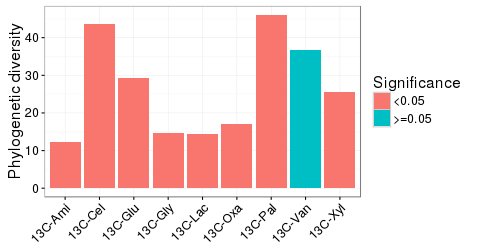

In [485]:
%%R -h 250 
# plotting phylogenetic diversity of each tree
pd.bySub$trait = pd.bySub %>% rownames
pd.bySub$padj = p.adjust(pd.bySub$pd.obs.p, method='BH')
pd.bySub$Significance = ifelse(pd.bySub$padj < 0.05, '<0.05', '>=0.05')

ggplot(pd.bySub, aes(trait, pd.obs, fill=Significance)) +
    geom_bar(stat='identity') +
    labs(y='Phylogenetic diversity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
        axis.title.x = element_blank()
    )

### D stat

In [756]:
%%R
D.bySub = phylo.d.multi(df.bySub, tree.p)
D.bySub %>% head(n=3)

  DEstimate Pval1 Pval0   Trait
1 0.9164608  0.07     0 13C-Ami
2 0.6901976  0.00     0 13C-Cel
3 0.6025728  0.00     0 13C-Glu


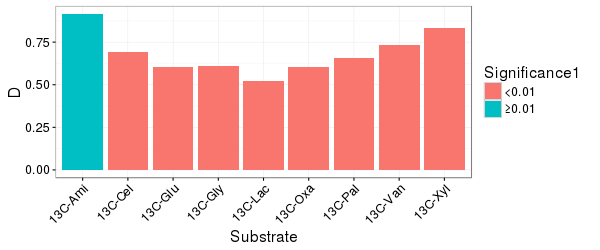

In [757]:
%%R -h 250 -w 600
D.bySub.e = D.bySub %>%
    mutate(Pval1.adj = p.adjust(Pval1, method='BH'),
           Pval0.adj = p.adjust(Pval0, method='BH'),
           Significance1 = ifelse(Pval1 < 0.01, '<0.01', '≥0.01'))

D.bySub.p = ggplot(D.bySub.e, aes(Trait, DEstimate, fill=Significance1)) +
    geom_bar(stat='identity') +
    labs(x='Substrate', y='D') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

D.bySub.p     

### mpd/mntd

In [488]:
%%R
phydist = cophenetic(tree.p)
mpd.bySub = ses.mpd(df.bySub %>% t, phydist, null.model=null.model)
mpd.bySub

        ntaxa   mpd.obs mpd.rand.mean mpd.rand.sd mpd.obs.rank mpd.obs.z
13C-Ami   108 0.7096024     0.8384647 0.027488424            1 -4.687875
13C-Cel   512 0.8522480     0.8401707 0.009989472          877  1.208997
13C-Glu   377 0.7449663     0.8397075 0.013619788            1 -6.956143
13C-Gly   167 0.6852861     0.8400931 0.021267748            1 -7.278956
13C-Lac   176 0.7095955     0.8396803 0.021721053            1 -5.988882
13C-Oxa   176 0.7543139     0.8387388 0.020830848            1 -4.052879
13C-Pal   511 0.8840575     0.8397487 0.010006985         1000  4.427791
13C-Van   340 0.8016661     0.8392006 0.013767651            7 -2.726282
13C-Xyl   266 0.7698571     0.8379135 0.016272758            1 -4.182228
        mpd.obs.p runs
13C-Ami     0.001  999
13C-Cel     0.877  999
13C-Glu     0.001  999
13C-Gly     0.001  999
13C-Lac     0.001  999
13C-Oxa     0.001  999
13C-Pal     1.000  999
13C-Van     0.007  999
13C-Xyl     0.001  999


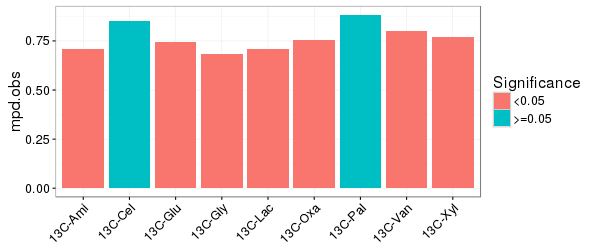

In [489]:
%%R -w 600 -h 250
mpd.bySub$Substrate = mpd.bySub %>% rownames

mpd.bySub$padj = p.adjust(mpd.bySub$mpd.obs.p, method='BH')
mpd.bySub$Significance = ifelse(mpd.bySub$padj < 0.05, '<0.05', '>=0.05')

ggplot(mpd.bySub, aes(Substrate, mpd.obs, fill=Significance)) +
    geom_bar(stat='identity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
        axis.title.x = element_blank()
    )

In [490]:
%%R
phydist = cophenetic(tree.p)
mntd.bySub = ses.mntd(df.bySub %>% t, phydist, null.model=null.model)
mntd.bySub

        ntaxa   mntd.obs mntd.rand.mean mntd.rand.sd mntd.obs.rank mntd.obs.z
13C-Ami   108 0.11175435      0.2051885  0.015239162             1  -6.131188
13C-Cel   512 0.08443549      0.1020550  0.003688605             1  -4.776749
13C-Glu   377 0.07698838      0.1183070  0.005160677             1  -8.006438
13C-Gly   167 0.08986246      0.1700316  0.010792549             1  -7.428195
13C-Lac   176 0.07868909      0.1658975  0.010353010             1  -8.423482
13C-Oxa   176 0.10377284      0.1664015  0.010374703             1  -6.036670
13C-Pal   511 0.08731751      0.1024376  0.003624932             1  -4.171128
13C-Van   340 0.11432591      0.1236040  0.005642936            46  -1.644199
13C-Xyl   266 0.09604004      0.1386096  0.007094910             1  -6.000017
        mntd.obs.p runs
13C-Ami      0.001  999
13C-Cel      0.001  999
13C-Glu      0.001  999
13C-Gly      0.001  999
13C-Lac      0.001  999
13C-Oxa      0.001  999
13C-Pal      0.001  999
13C-Van      0.046  999
13C-

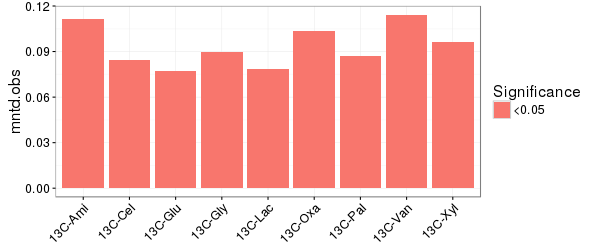

In [491]:
%%R -w 600 -h 250
mntd.bySub$Substrate = mntd.bySub %>% rownames

mntd.bySub$padj = p.adjust(mntd.bySub$mntd.obs.p, method='BH')
mntd.bySub$Significance = ifelse(mntd.bySub$padj < 0.05, '<0.05', '>=0.05')

ggplot(mntd.bySub, aes(Substrate, mntd.obs, fill=Significance)) +
    geom_bar(stat='identity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
        axis.title.x = element_blank()
    )

## By substrate & day

In [793]:
%%R
df.bySubDay = read.delim('incorp_trait_bySubDay.txt', header=FALSE)
rownames(df.bySubDay) = df.bySubDay$V1
df.bySubDay$V1 = NULL
 colnames(df.bySubDay) = c(
'13C-Ami_D1',
'13C-Ami_D14',
'13C-Ami_D3',
'13C-Ami_D6',
'13C-Cel_D14',
'13C-Cel_D3',
'13C-Cel_D30',
'13C-Cel_D48',
'13C-Cel_D6',
'13C-Glu_D1',
'13C-Glu_D14',
'13C-Glu_D3',
'13C-Glu_D6',
'13C-Gly_D1',
'13C-Gly_D14',
'13C-Gly_D3',
'13C-Gly_D6',
'13C-Lac_D1',
'13C-Lac_D3',
'13C-Lac_D6',
'13C-Oxa_D14',
'13C-Oxa_D3',
'13C-Oxa_D6',
'13C-Pal_D14',
'13C-Pal_D30',
'13C-Pal_D48',
'13C-Pal_D6',
'13C-Van_D14',
'13C-Van_D30',
'13C-Van_D48',
'13C-Van_D6',
'13C-Xyl_D1',
'13C-Xyl_D14',
'13C-Xyl_D3',
'13C-Xyl_D6')
df.bySubDay %>% head

          13C-Ami_D1 13C-Ami_D14 13C-Ami_D3 13C-Ami_D6 13C-Cel_D14 13C-Cel_D3
OTU.1              0           0          0          0           0          0
OTU.10             0           0          0          0           0          0
OTU.100            0           0          0          0           0          0
OTU.10019          0           0          0          0           1          0
OTU.1002           0           0          0          0           0          0
OTU.1004           0           0          0          0           1          0
          13C-Cel_D30 13C-Cel_D48 13C-Cel_D6 13C-Glu_D1 13C-Glu_D14 13C-Glu_D3
OTU.1               0           0          0          0           0          0
OTU.10              0           1          0          0           1          0
OTU.100             1           1          0          0           0          0
OTU.10019           1           0          0          0           0          0
OTU.1002            1           0          0          0    

In [794]:
%%R
tree.p = pruneTree(real.tree, rownames(df.bySubDay))

# checking that tree and traits match
stopifnot(length(tree.p$tip) == nrow(df.bySubDay))
df.bySubDay = df.bySubDay[tree.p$tip, ]

# stats
tree.p


Phylogenetic tree with 1287 tips and 1286 internal nodes.

Tip labels:
	OTU.2006, OTU.11824, OTU.900, OTU.316, OTU.8650, OTU.6379, ...
Node labels:
	, 0.622.5, 0.414.4, 0.845.38, 0.969.23, 0.724.25, ...

Rooted; includes branch lengths.


### PD

In [495]:
%%R 
# plotting phylogenetic diversity of each tree
pd.bySubDay = ses.pd(df.bySubDay %>% t, tree.p, null.model=null.model)
pd.bySubDay %>% head(n=3)

            ntaxa   pd.obs pd.rand.mean pd.rand.sd pd.obs.rank  pd.obs.z
13C-Ami_D1     24  3.54631     6.900504  0.6130775           1 -5.471076
13C-Ami_D14    80 11.30863    15.576841  0.8328868           1 -5.124599
13C-Ami_D3      7  1.70546     2.656777  0.4178179          10 -2.276870
            pd.obs.p runs
13C-Ami_D1     0.001  999
13C-Ami_D14    0.001  999
13C-Ami_D3     0.010  999


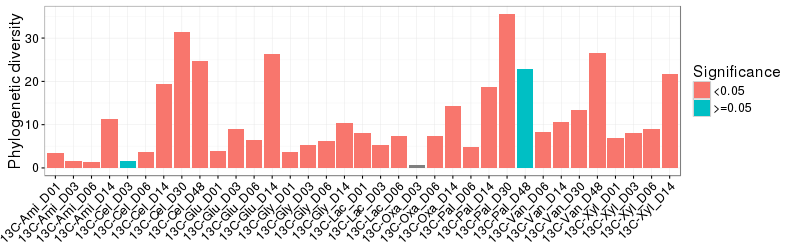

In [496]:
%%R -h 250 -w 800
# plotting phylogenetic diversity of each tree
pd.bySubDay$trait = pd.bySubDay %>% rownames
pd.bySubDay$trait = gsub('_D([0-9])$', '_D0\\1', pd.bySubDay$trait)
pd.bySubDay$padj = p.adjust(pd.bySubDay$pd.obs.p, method='BH')
pd.bySubDay$Significance = ifelse(pd.bySubDay$padj < 0.05, '<0.05', '>=0.05')

ggplot(pd.bySubDay, aes(trait, pd.obs, fill=Significance)) +
    geom_bar(stat='identity') +
    labs(y='Phylogenetic diversity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
        axis.title.x = element_blank()
    )

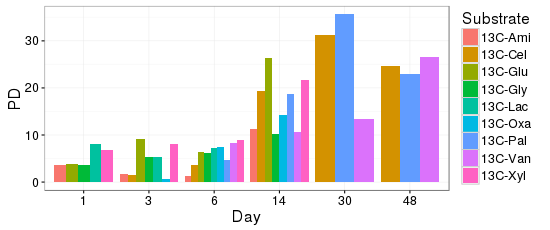

In [840]:
%%R -h 230 -w 550
# plotting phylogenetic diversity of each tree
pd.bySubDay.e = pd.bySubDay %>%
    mutate(trait = rownames(.),
           trait = gsub('_D([0-9])$', '_D0\\1', trait),
           padj = p.adjust(pd.bySubDay$pd.obs.p, method='BH'),
           Significance = ifelse(pd.bySubDay$padj < 0.05, '<0.05', '>=0.05')) %>%
    separate(trait, c('Substrate', 'Day'), sep='_') %>%
    mutate(Day = gsub('D0*', '', Day),
           Day = Day %>% reorder(Day %>% as.numeric))

# plotting
ggplot(pd.bySubDay.e, aes(Day, pd.obs, fill=Substrate)) +
    geom_bar(stat='identity', position='dodge') +
    labs(y='PD') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

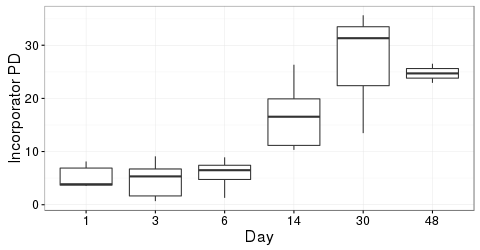

In [852]:
%%R -h 250
# plotting
ggplot(pd.bySubDay.e, aes(Day, pd.obs)) +
    geom_boxplot() +
    labs(y='Incorporator PD') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [848]:
%%R
# correlation: PD ~ Day
cor.test(pd.bySubDay.e$Day %>% as.numeric, pd.bySubDay.e$pd.obs, method='spearman')


	Spearman's rank correlation rho

data:  pd.bySubDay.e$Day %>% as.numeric and pd.bySubDay.e$pd.obs
S = 1367.4, p-value = 4.239e-09
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.8084903 



### D stat

In [795]:
%%R
D.bySubDay = phylo.d.multi(df.bySubDay, tree.p)
D.bySubDay %>% head(n=3)

  DEstimate Pval1 Pval0       Trait
1 0.8550642 0.166 0.000  13C-Ami_D1
2 1.0466459 0.761 0.000 13C-Ami_D14
3 1.2330963 0.758 0.005  13C-Ami_D3


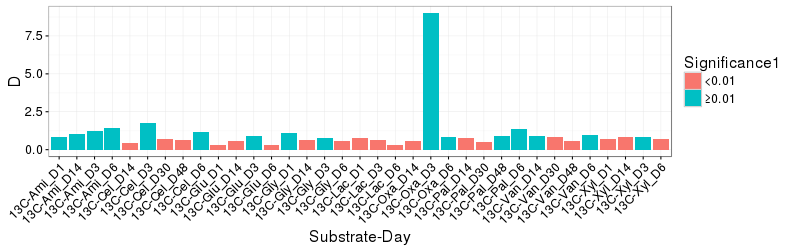

In [822]:
%%R -h 250 -w 800
D.bySubDay = D.bySubDay %>%
    mutate(Pval1.adj = p.adjust(Pval1, method='BH'),
           Pval0.adj = p.adjust(Pval0, method='BH'),
           Significance1 = ifelse(Pval1 < 0.01, '<0.01', '≥0.01'))

D.bySubDay.p = ggplot(D.bySubDay, aes(Trait, DEstimate, fill=Significance1)) +
    geom_bar(stat='identity') +
    #scale_x_continuous(breaks=seq(1,26,5)) +
    labs(x='Substrate-Day', y='D') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )
D.bySubDay.p     

### mpd/mntd

In [499]:
%%R
phydist = cophenetic(tree.p)
mpd.bySubDay = ses.mpd(df.bySubDay %>% t, phydist, null.model=null.model)
mpd.bySubDay

            ntaxa   mpd.obs mpd.rand.mean mpd.rand.sd mpd.obs.rank  mpd.obs.z
13C-Ami_D1     24 0.5569263     0.8393919  0.06183433            1 -4.5681029
13C-Ami_D14    80 0.7277123     0.8393416  0.03218611            1 -3.4682441
13C-Ami_D3      7 0.6502419     0.8345493  0.11608219           43 -1.5877321
13C-Ami_D6      6 0.4835387     0.8297510  0.12842424            1 -2.6958486
13C-Cel_D14   170 0.8428192     0.8402020  0.02126290          534  0.1230877
13C-Cel_D3      5 0.6190480     0.8389987  0.14415489           45 -1.5257941
13C-Cel_D30   321 0.8206838     0.8396416  0.01408726           87 -1.3457417
13C-Cel_D48   201 0.8715331     0.8403325  0.01973326          944  1.5811177
13C-Cel_D6     18 0.6505034     0.8424950  0.07236374            1 -2.6531468
13C-Glu_D1     46 0.4998715     0.8379553  0.04308129            1 -7.8475789
13C-Glu_D14   317 0.7441618     0.8395517  0.01412035            1 -6.7554927
13C-Glu_D3     73 0.7004055     0.8392485  0.03452984           

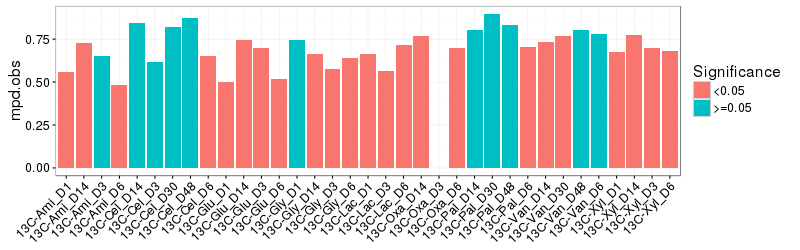

In [500]:
%%R -w 800 -h 250
mpd.bySubDay$Substrate = mpd.bySubDay %>% rownames

mpd.bySubDay$padj = p.adjust(mpd.bySubDay$mpd.obs.p, method='BH')
mpd.bySubDay$Significance = ifelse(mpd.bySubDay$padj < 0.05, '<0.05', '>=0.05')

ggplot(mpd.bySubDay, aes(Substrate, mpd.obs, fill=Significance)) +
    geom_bar(stat='identity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
        axis.title.x = element_blank()
    )

In [501]:
%%R
phydist = cophenetic(tree.p)
mntd.bySubDay = ses.mntd(df.bySubDay %>% t, phydist, null.model=null.model)
mntd.bySubDay

            ntaxa   mntd.obs mntd.rand.mean mntd.rand.sd mntd.obs.rank
13C-Ami_D1     24 0.14034417      0.3767691  0.049422569             1
13C-Ami_D14    80 0.14552238      0.2326737  0.018963861             1
13C-Ami_D3      7 0.19586143      0.5805806  0.114840806             1
13C-Ami_D6      6 0.20667833      0.5963978  0.128424667             1
13C-Cel_D14   170 0.10894918      0.1688850  0.010566037             1
13C-Cel_D3      5 0.42641600      0.6360954  0.136974186            63
13C-Cel_D30   321 0.09557174      0.1275382  0.006097328             1
13C-Cel_D48   201 0.12696965      0.1568905  0.008807636             1
13C-Cel_D6     18 0.20989778      0.4211486  0.059127124             1
13C-Glu_D1     46 0.05961500      0.2936624  0.031346575             1
13C-Glu_D14   317 0.08595448      0.1280853  0.006103032             1
13C-Glu_D3     73 0.11118507      0.2429497  0.020242161             1
13C-Glu_D6     60 0.10783750      0.2632965  0.025144666             1
13C-Gl

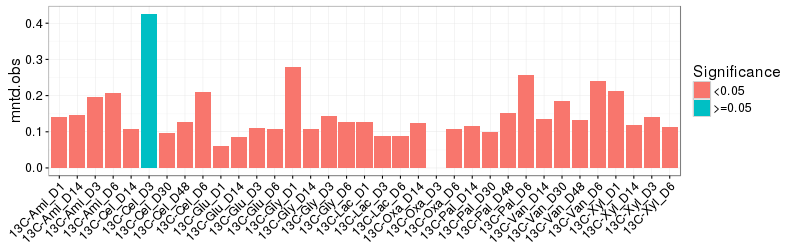

In [502]:
%%R -w 800 -h 250
mntd.bySubDay$Substrate = mntd.bySubDay %>% rownames

mntd.bySubDay$padj = p.adjust(mntd.bySubDay$mntd.obs.p, method='BH')
mntd.bySubDay$Significance = ifelse(mntd.bySubDay$padj < 0.05, '<0.05', '>=0.05')

ggplot(mntd.bySubDay, aes(Substrate, mntd.obs, fill=Significance)) +
    geom_bar(stat='identity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
        axis.title.x = element_blank()
    )

## By functional group

In [782]:
%%R
df.byFG = read.delim('incorp_trait_funcG.txt', header=FALSE)
rownames(df.byFG) = df.byFG$V1
df.byFG$V1 = NULL

colnames(df.byFG) = gsub('^', 'FG', 1:ncol(df.byFG))
df.byFG %>% head(n=3)

        FG1 FG2 FG3 FG4 FG5 FG6 FG7 FG8 FG9 FG10 FG11 FG12 FG13 FG14 FG15 FG16
OTU.1     0   0   0   0   0   0   0   0   0    0    0    0    0    0    0    0
OTU.10    0   0   0   0   1   0   0   0   0    0    0    0    0    0    0    0
OTU.100   0   0   0   0   0   0   0   0   0    0    0    0    0    0    0    0
        FG17 FG18 FG19 FG20 FG21 FG22 FG23 FG24 FG25 FG26
OTU.1      0    0    0    0    0    0    0    0    1    0
OTU.10     0    0    0    0    0    0    0    0    0    0
OTU.100    0    0    0    0    1    0    0    0    0    0


In [783]:
%%R
tree.p = pruneTree(real.tree, rownames(df.byFG))

# checking that tree and traits match
stopifnot(length(tree.p$tip) == nrow(df.byFG))
df.byFG = df.byFG[tree.p$tip, ]

# stats
tree.p


Phylogenetic tree with 1287 tips and 1286 internal nodes.

Tip labels:
	OTU.2006, OTU.11824, OTU.900, OTU.316, OTU.8650, OTU.6379, ...
Node labels:
	, 0.622.5, 0.414.4, 0.845.38, 0.969.23, 0.724.25, ...

Rooted; includes branch lengths.


### PD

In [505]:
%%R
# plotting phylogenetic diversity of each tree
pd.byFG = ses.pd(df.byFG %>% t, tree.p, null.model=null.model)
pd.byFG

     ntaxa   pd.obs pd.rand.mean pd.rand.sd pd.obs.rank    pd.obs.z pd.obs.p
FG1    110 12.81528    19.159339  0.8490876           1 -7.47161936    0.001
FG2     96 11.55337    17.596240  0.8516279           1 -7.09566923    0.001
FG3     83 13.52730    15.993241  0.8745984           3 -2.81951245    0.003
FG4     76 13.21402    15.103502  0.8510520          13 -2.22017228    0.013
FG5     60  5.77282    12.988035  0.7727279           1 -9.33733023    0.001
FG6     58 13.20384    12.676014  0.7604528         760  0.69409460    0.760
FG7     57  6.44269    12.525781  0.8008774           1 -7.59553424    0.001
FG8     54  8.96272    12.110189  0.7431290           1 -4.23542794    0.001
FG9     51 12.74357    11.655428  0.7258366         933  1.49915563    0.933
FG10    50  6.54212    11.479560  0.7304738           1 -6.75922975    0.001
FG11    49 11.25887    11.313689  0.7079079         472 -0.07743811    0.472
FG12    48 11.79950    11.176815  0.7163997         801  0.86918727    0.801

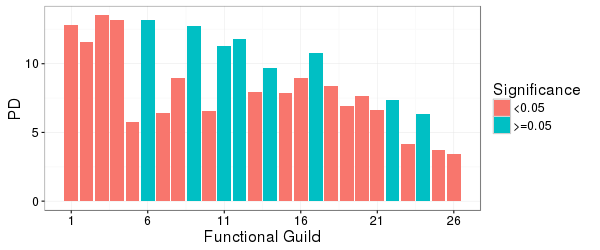

In [506]:
%%R -h 250 -w 600
# plotting phylogenetic diversity of each tree
pd.byFG$trait = pd.byFG %>% rownames
#pd.byFG$trait = reorder(pd.byFG$trait, gsub('FG', '', pd.byFG$trait) %>% as.numeric)
pd.byFG$FG_e = gsub('FG', '', pd.byFG$trait) %>% as.numeric

pd.byFG$padj = p.adjust(pd.byFG$pd.obs.p, method='BH')
pd.byFG$Significance = ifelse(pd.byFG$padj < 0.05, '<0.05', '>=0.05')

ggplot(pd.byFG, aes(FG_e, pd.obs, fill=Significance)) +
    geom_bar(stat='identity') +
    scale_x_continuous(breaks=seq(1,26,5)) +
    labs(x='Functional Guild', y='PD') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### D stat

In [784]:
%%R
D.byFG = phylo.d.multi(df.byFG, tree.p)
D.byFG %>% head(n=3)

  DEstimate Pval1 Pval0 Trait
1 0.3869401     0     0   FG1
2 0.6874508     0     0   FG2
3 0.6604353     0     0   FG3


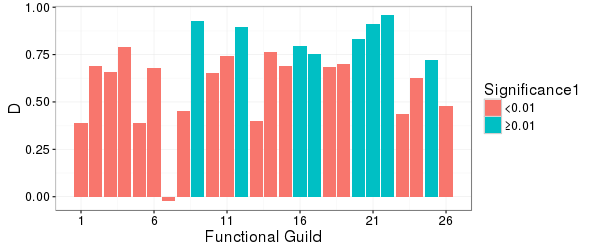

In [785]:
%%R -h 250 -w 600
D.byFG = D.byFG %>%
    mutate(FG = gsub('FG', '', rownames(.)) %>% as.numeric,
           Pval1.adj = p.adjust(Pval1, method='BH'),
           Pval0.adj = p.adjust(Pval0, method='BH'),
           Significance1 = ifelse(Pval1 < 0.01, '<0.01', '≥0.01'))


ggplot(D.byFG, aes(FG, DEstimate, fill=Significance1)) +
    geom_bar(stat='identity') +
    scale_x_continuous(breaks=seq(1,26,5)) +
    labs(x='Functional Guild', y='D') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
    

In [786]:
%pushnote phylo.d.multi complete

### mpd/mntd

In [509]:
%%R
phydist = cophenetic(tree.p)
mpd.byFG = ses.mpd(df.byFG %>% t, phydist, null.model=null.model)
mpd.byFG

     ntaxa   mpd.obs mpd.rand.mean mpd.rand.sd mpd.obs.rank    mpd.obs.z
FG1    110 0.6462391     0.8395310  0.02826485            1 -6.838595772
FG2     96 0.6867247     0.8399617  0.02775638            1 -5.520784853
FG3     83 0.9283298     0.8398163  0.03070040          996  2.883140744
FG4     76 0.8401898     0.8399666  0.03432167          484  0.006501677
FG5     60 0.5009229     0.8405506  0.03747847            1 -9.061942200
FG6     58 0.9143897     0.8394407  0.03843713          970  1.949912449
FG7     57 0.6798568     0.8370448  0.03825091            1 -4.109394869
FG8     54 0.8074404     0.8377623  0.03907343          224 -0.776022866
FG9     51 0.9316398     0.8400519  0.04129442          989  2.217924331
FG10    50 0.6153608     0.8415007  0.04100217            1 -5.515317107
FG11    49 0.8957935     0.8412435  0.04170874          904  1.307879621
FG12    48 0.9539327     0.8405190  0.04281481          992  2.648937065
FG13    48 0.7299875     0.8394303  0.04237929     

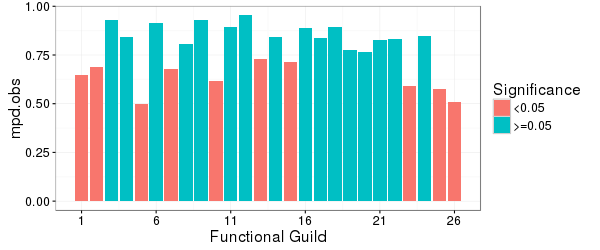

In [510]:
%%R -w 600 -h 250
mpd.byFG$FG = mpd.byFG %>% rownames
mpd.byFG$FG_e = gsub('FG', '', mpd.byFG$FG) %>% as.numeric

mpd.byFG$padj = p.adjust(mpd.byFG$mpd.obs.p, method='BH')
mpd.byFG$Significance = ifelse(mpd.byFG$padj < 0.05, '<0.05', '>=0.05')

ggplot(mpd.byFG, aes(FG_e, mpd.obs, fill=Significance)) +
    geom_bar(stat='identity') +
    scale_x_continuous(breaks=seq(1,26,5)) +
    labs(x='Functional Guild') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [511]:
%%R
phydist = cophenetic(tree.p)
mntd.byFG = ses.mntd(df.byFG %>% t, phydist, null.model=null.model)
mntd.byFG

     ntaxa   mntd.obs mntd.rand.mean mntd.rand.sd mntd.obs.rank mntd.obs.z
FG1    110 0.12982518      0.2039778   0.01545378             1 -4.7983495
FG2     96 0.12529677      0.2154028   0.01684560             1 -5.3489374
FG3     83 0.17240325      0.2292765   0.01878875             1 -3.0269866
FG4     76 0.18426000      0.2382405   0.02045713             5 -2.6387129
FG5     60 0.09784933      0.2637632   0.02390491             1 -6.9405757
FG6     58 0.27179293      0.2662178   0.02505923           604  0.2224772
FG7     57 0.12140368      0.2679585   0.02706871             1 -5.4141801
FG8     54 0.17910741      0.2729038   0.02664066             1 -3.5207990
FG9     51 0.32543353      0.2801005   0.02767905           933  1.6378089
FG10    50 0.12552780      0.2853047   0.02799310             1 -5.7077227
FG11    49 0.30181673      0.2864455   0.02928326           704  0.5249171
FG12    48 0.31426958      0.2874680   0.02964932           808  0.9039531
FG13    48 0.17005813    

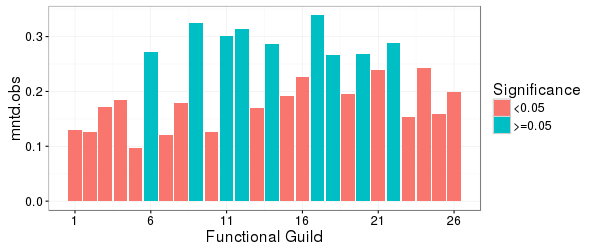

In [512]:
%%R -w 600 -h 250
mntd.byFG$FG = mntd.byFG %>% rownames
mntd.byFG$FG_e = gsub('FG', '', mntd.byFG$FG) %>% as.numeric

mntd.byFG$padj = p.adjust(mntd.byFG$mntd.obs.p, method='BH')
mntd.byFG$Significance = ifelse(mntd.byFG$padj < 0.05, '<0.05', '>=0.05')

ggplot(mntd.byFG, aes(FG_e, mntd.obs, fill=Significance)) +
    geom_bar(stat='identity') +
    scale_x_continuous(breaks=seq(1,26,5)) +
    labs(x='Functional Guild') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [797]:
%pushnote done

# Combined figure of PD, K, & TauD

## Gathering data

In [764]:
%%R
bySub = c(
'13C-Ami',
'13C-Cel',
'13C-Glu',
'13C-Gly',
'13C-Lac',
'13C-Oxa',
'13C-Pal',
'13C-Van',
'13C-Xyl')

bySubDay = c(
'13C-Ami_D1',
'13C-Ami_D14',
'13C-Ami_D3',
'13C-Ami_D6',
'13C-Cel_D14',
'13C-Cel_D3',
'13C-Cel_D30',
'13C-Cel_D48',
'13C-Cel_D6',
'13C-Glu_D1',
'13C-Glu_D14',
'13C-Glu_D3',
'13C-Glu_D6',
'13C-Gly_D1',
'13C-Gly_D14',
'13C-Gly_D3',
'13C-Gly_D6',
'13C-Lac_D1',
'13C-Lac_D3',
'13C-Lac_D6',
'13C-Oxa_D14',
'13C-Oxa_D3',
'13C-Oxa_D6',
'13C-Pal_D14',
'13C-Pal_D30',
'13C-Pal_D48',
'13C-Pal_D6',
'13C-Van_D14',
'13C-Van_D30',
'13C-Van_D48',
'13C-Van_D6',
'13C-Xyl_D1',
'13C-Xyl_D14',
'13C-Xyl_D3',
'13C-Xyl_D6')

byFG = gsub('^', 'FG', 1:26)

### concenTRAIT

In [765]:
%%R
as.Num = function(x) x %>% as.character %>% as.numeric

In [768]:
%%R
# table loading
df.CT.sub = read.delim('incorp_trait_bySub_tauD.txt', sep='\t')
df.CT.subDay = read.delim('incorp_trait_bySubDay_tauD.txt', sep='\t')
df.CT.FG = read.delim('incorp_trait_funcG_tauD.txt', sep='\t')

# adding trait info
df.CT.sub$Trait = bySub
df.CT.subDay$Trait = bySubDay
df.CT.FG$Trait = byFG

# rbind
df.CT = rbind(df.CT.sub %>% mutate(Substrate=Trait, Day=NA, FG=NA), 
              df.CT.subDay %>% mutate(Substrate=gsub('_.+','', Trait),
                                      Day=gsub('.+_D', '', Trait) %>% as.Num,
                                      FG=NA),
              df.CT.FG %>% mutate(Day=NA,Substrate=NA,FG=gsub('FG','',Trait) %>% as.Num))

# p-value adjustment
df.CT$P_adj = p.adjust(df.CT$p.value, method='BH')


# formating
df.CT = df.CT %>%
    mutate(stat='Tau D') %>%
    dplyr::select(Substrate, Day, FG, tau_D, P_adj, stat) %>%
    rename('value' = tau_D)

# status
df.CT %>% head(n=3)

  Substrate Day FG      value     P_adj  stat
1   13C-Ami  NA NA 0.01105993 0.0000000 Tau D
2   13C-Cel  NA NA 0.02051219 0.7491228 Tau D
3   13C-Glu  NA NA 0.01450248 0.0000000 Tau D


### phylo.D

In [799]:
%%R
D.bySub %>% head

  DEstimate Pval1 Pval0   Trait
1 0.9164608  0.07     0 13C-Ami
2 0.6901976  0.00     0 13C-Cel
3 0.6025728  0.00     0 13C-Glu
4 0.6117780  0.00     0 13C-Gly
5 0.5199997  0.00     0 13C-Lac
6 0.6013780  0.00     0 13C-Oxa


In [801]:
%%R
D.bySubDay %>% head

  DEstimate Pval1 Pval0       Trait Substrate Pval1.adj   Pval0.adj
1 0.8550642 0.166 0.000  13C-Ami_D1         1 0.2234615 0.000000000
2 1.0466459 0.761 0.000 13C-Ami_D14         2 0.8878333 0.000000000
3 1.2330963 0.758 0.005  13C-Ami_D3         3 0.8878333 0.005645161
4 1.4152262 0.839 0.000  13C-Ami_D6         4 0.9362500 0.000000000
5 0.4738731 0.000 0.000 13C-Cel_D14         5 0.0000000 0.000000000
6 1.7341091 0.923 0.001  13C-Cel_D3         6 0.9789394 0.001166667
  Significance1
1         ≥0.01
2         ≥0.01
3         ≥0.01
4         ≥0.01
5         <0.01
6         ≥0.01


In [800]:
%%R
D.byFG %>% head

  DEstimate Pval1 Pval0 Trait FG Pval1.adj  Pval0.adj Significance1
1 0.3869401 0.000 0.000   FG1  1  0.000000 0.00000000         <0.01
2 0.6874508 0.000 0.000   FG2  2  0.000000 0.00000000         <0.01
3 0.6604353 0.000 0.000   FG3  3  0.000000 0.00000000         <0.01
4 0.7925744 0.001 0.000   FG4  4  0.001625 0.00000000         <0.01
5 0.3889819 0.000 0.009   FG5  5  0.000000 0.01017391         <0.01
6 0.6772839 0.000 0.000   FG6  6  0.000000 0.00000000         <0.01


In [803]:
%%R
# rbind
df.D = rbind(D.bySub %>% mutate(Substrate=Trait, Day=NA, FG=NA), 
              D.bySubDay %>% dplyr::select(DEstimate, Pval1, Pval0, Trait) %>%
                             mutate(Substrate=gsub('_.+','', Trait),
                                     Day=gsub('.+_D0*', '', Trait),
                                     FG=NA),
              D.byFG %>% dplyr::select(DEstimate, Pval1, Pval0, Trait) %>%
                 mutate(Day=NA,Substrate=NA,FG=gsub('FG', '', Trait)))
df.D %>% head

  DEstimate Pval1 Pval0   Trait Substrate  Day   FG
1 0.9164608  0.07     0 13C-Ami   13C-Ami <NA> <NA>
2 0.6901976  0.00     0 13C-Cel   13C-Cel <NA> <NA>
3 0.6025728  0.00     0 13C-Glu   13C-Glu <NA> <NA>
4 0.6117780  0.00     0 13C-Gly   13C-Gly <NA> <NA>
5 0.5199997  0.00     0 13C-Lac   13C-Lac <NA> <NA>
6 0.6013780  0.00     0 13C-Oxa   13C-Oxa <NA> <NA>


In [807]:
%%R
# rbind
df.D = rbind(D.bySub %>% mutate(Substrate=Trait, Day=NA, FG=NA), 
              D.bySubDay %>% dplyr::select(DEstimate, Pval1, Pval0, Trait) %>%
                             mutate(Substrate=gsub('_.+','', Trait),
                                     Day=gsub('.+_D0*', '', Trait),
                                     FG=NA),
              D.byFG %>% dplyr::select(DEstimate, Pval1, Pval0, Trait) %>%
                 mutate(Day=NA,Substrate=NA,FG=gsub('FG', '', Trait)))

# p-value adjustment
df.D$P_adj = p.adjust(df.D$Pval1, method='BH')


# formating
df.D = df.D %>%
    mutate(stat='D') %>%
    dplyr::select(Substrate, Day, FG, DEstimate, P_adj, stat) %>%
    rename('value' = DEstimate)


df.D %>% head(n=3)

  Substrate  Day   FG     value      P_adj stat
1   13C-Ami <NA> <NA> 0.9164608 0.08909091    D
2   13C-Cel <NA> <NA> 0.6901976 0.00000000    D
3   13C-Glu <NA> <NA> 0.6025728 0.00000000    D


### PD

In [808]:
%%R
# rbind
df.pd = rbind(pd.bySub %>% mutate(Substrate=trait, Day=NA, FG=NA), 
              pd.bySubDay %>% mutate(Substrate=gsub('_.+','', trait),
                                     Day=gsub('.+_D0*', '', trait),
                                     FG=NA),
              pd.byFG %>% dplyr::select(-FG_e) %>% mutate(Day=NA,Substrate=NA,FG=gsub('FG', '', trait)))

# p-value adjustment
df.pd$P_adj = p.adjust(df.pd$pd.obs.p, method='BH')


# formating
df.pd = df.pd %>%
    mutate(stat='PD') %>%
    dplyr::select(Substrate, Day, FG, pd.obs, P_adj, stat) %>%
    rename('value' = pd.obs)


df.pd %>% head(n=3)

  Substrate  Day   FG    value       P_adj stat
1   13C-Ami <NA> <NA> 12.38319 0.001604651   PD
2   13C-Cel <NA> <NA> 43.73049 0.001604651   PD
3   13C-Glu <NA> <NA> 29.18204 0.001604651   PD


### mpd

In [809]:
%%R
# rbind
mpd.bySub$trait = mpd.bySub %>% rownames
mpd.bySubDay$trait = mpd.bySubDay %>% rownames
mpd.byFG$trait = mpd.byFG %>% rownames


df.mpd = rbind(mpd.bySub %>% mutate(Substrate=trait, Day=NA, FG=NA), 
              mpd.bySubDay %>% mutate(Substrate=gsub('_.+','', trait),
                                     Day=gsub('.+_D0*', '', trait),
                                     FG=NA),
              mpd.byFG %>% dplyr::select(-FG_e) %>% mutate(Day=NA,Substrate=NA,FG=gsub('FG', '', trait)))

# p-value adjustment
df.mpd$P_adj = p.adjust(df.mpd$mpd.obs.p, method='BH')


# formating
df.mpd = df.mpd %>%
    mutate(stat='mpd') %>%
    dplyr::select(Substrate, Day, FG, mpd.obs, P_adj, stat) %>%
    rename('value' = mpd.obs)


df.mpd %>% head(n=3)

  Substrate  Day   FG     value       P_adj stat
1   13C-Ami <NA> <NA> 0.7096024 0.002029412  mpd
2   13C-Cel <NA> <NA> 0.8522480 0.993147541  mpd
3   13C-Glu <NA> <NA> 0.7449663 0.002029412  mpd


### mntd

In [810]:
%%R
# rbind
mntd.bySub$trait = mntd.bySub %>% rownames
mntd.bySubDay$trait = mntd.bySubDay %>% rownames
mntd.byFG$trait = mntd.byFG %>% rownames


df.mntd = rbind(mntd.bySub %>% mutate(Substrate=trait, Day=NA, FG=NA), 
              mntd.bySubDay %>% mutate(Substrate=gsub('_.+','', trait),
                                     Day=gsub('.+_D0*', '', trait),
                                     FG=NA),
              mntd.byFG %>% dplyr::select(-FG_e) %>% mutate(Day=NA,Substrate=NA,FG=gsub('FG', '', trait)))

# p-value adjustment
df.mntd$P_adj = p.adjust(df.mntd$mntd.obs.p, method='BH')


# formating
df.mntd = df.mntd %>%
    mutate(stat='mntd') %>%
    dplyr::select(Substrate, Day, FG, mntd.obs, P_adj, stat) %>%
    rename('value' = mntd.obs)


df.mntd %>% head(n=3)

  Substrate  Day   FG      value       P_adj stat
1   13C-Ami <NA> <NA> 0.11175435 0.001468085 mntd
2   13C-Cel <NA> <NA> 0.08443549 0.001468085 mntd
3   13C-Glu <NA> <NA> 0.07698838 0.001468085 mntd


### Combining

In [812]:
%%R
df.all = rbind(df.CT %>% mutate(Day = Day %>% as.Num,
                                FG = FG %>% as.Num),
               df.D %>% mutate(Day = Day %>% as.Num,
                                FG = FG %>% as.Num),
               df.pd %>% mutate(Day = Day %>% as.Num,
                                FG = FG %>% as.Num),
               df.mpd %>% mutate(Day = Day %>% as.Num,
                               FG = FG %>% as.Num),
               df.mntd %>% mutate(Day = Day %>% as.Num,
                               FG = FG %>% as.Num))

# significance
df.all = df.all %>%
    mutate(Significance = ifelse(P_adj<0.01, '<0.01', '≥0.01'))

df.all %>% head

  Substrate Day FG      value     P_adj  stat Significance
1   13C-Ami  NA NA 0.01105993 0.0000000 Tau D        <0.01
2   13C-Cel  NA NA 0.02051219 0.7491228 Tau D        ≥0.01
3   13C-Glu  NA NA 0.01450248 0.0000000 Tau D        <0.01
4   13C-Gly  NA NA 0.01128889 0.0000000 Tau D        <0.01
5   13C-Lac  NA NA 0.01289351 0.0000000 Tau D        <0.01
6   13C-Oxa  NA NA 0.01196239 0.0000000 Tau D        <0.01


### Plotting 

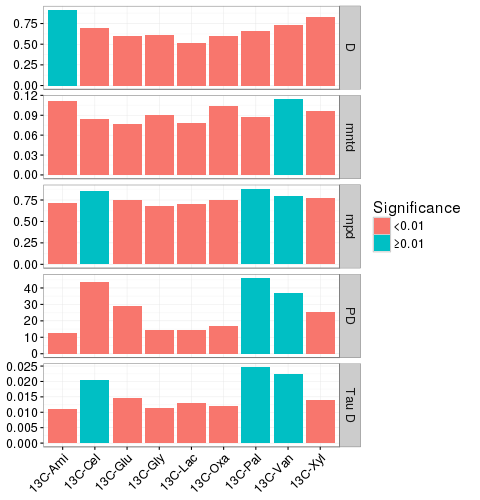

In [813]:
%%R -h 500
df.bySub = df.all %>%
    filter((is.na(Day) & is.na(FG)))


p.bySub = ggplot(df.bySub, aes(Substrate, value, fill=Significance)) +
    geom_bar(stat='identity', position='dodge') +
    facet_grid(stat ~ ., scales='free_y') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
        axis.title.x = element_blank(),
        axis.title.y = element_blank()        
    )
p.bySub    

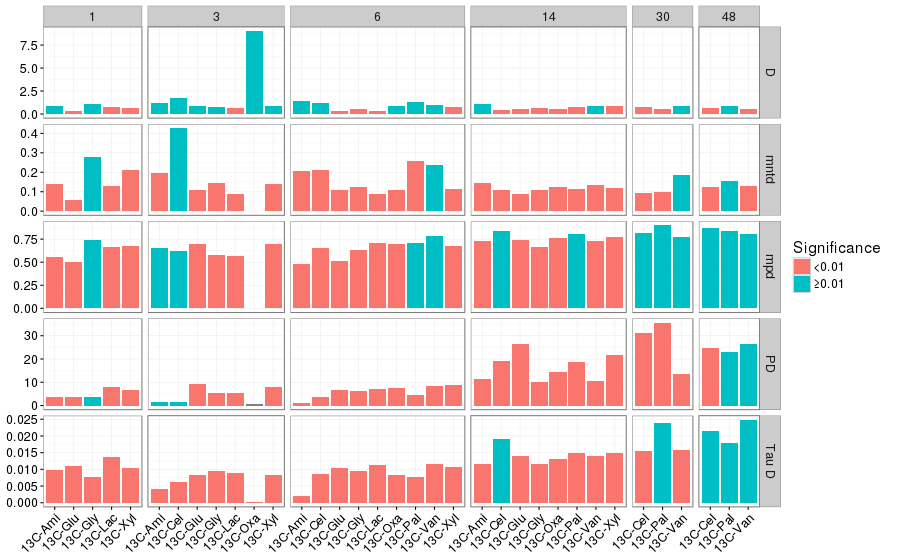

In [814]:
%%R -w 900 -h 560
df.bySubDay = df.all %>%
    filter((!is.na(Day) & !is.na(Substrate)))


p.bySubDay = ggplot(df.bySubDay, aes(Substrate, value, fill=Significance)) +
    geom_bar(stat='identity', position='dodge') +
    facet_grid(stat ~ Day, scales='free', space='free_x') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
        axis.title.x = element_blank(),
        axis.title.y = element_blank()        
    )
p.bySubDay 

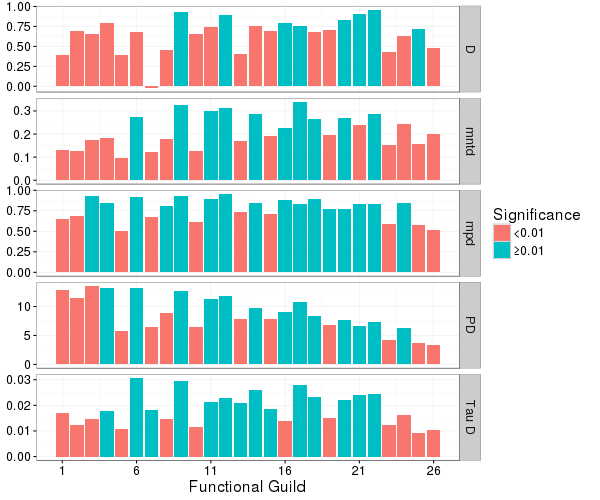

In [815]:
%%R -h 500 -w 600
df.byFG = df.all %>%
    filter(!is.na(FG))


p.byFG = ggplot(df.byFG, aes(FG, value, fill=Significance)) +
    geom_bar(stat='identity', position='dodge') +
    scale_x_continuous(breaks=seq(1,26,5)) +
    facet_grid(stat ~ ., scales='free_y') +
    labs(x='Functional Guild') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.y = element_blank()
    )
p.byFG 

## Just PD & TauD

In [860]:
%%R
df.all = rbind(df.CT %>% mutate(Day = Day %>% as.Num,
                                FG = FG %>% as.Num),
               df.pd %>% mutate(Day = Day %>% as.Num,
                                FG = FG %>% as.Num))

# significance
df.all = df.all %>%
    mutate(Significance = ifelse(P_adj<0.01, '<0.01', '≥0.01'))

df.all %>% head

  Substrate Day FG      value     P_adj  stat Significance
1   13C-Ami  NA NA 0.01105993 0.0000000 Tau D        <0.01
2   13C-Cel  NA NA 0.02051219 0.7491228 Tau D        ≥0.01
3   13C-Glu  NA NA 0.01450248 0.0000000 Tau D        <0.01
4   13C-Gly  NA NA 0.01128889 0.0000000 Tau D        <0.01
5   13C-Lac  NA NA 0.01289351 0.0000000 Tau D        <0.01
6   13C-Oxa  NA NA 0.01196239 0.0000000 Tau D        <0.01


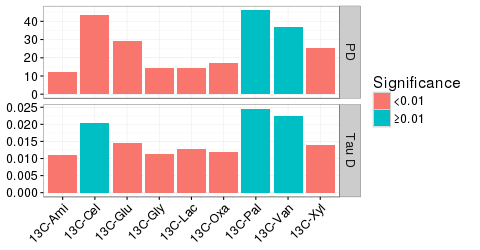

In [862]:
%%R -h 250
df.bySub = df.all %>%
    filter((is.na(Day) & is.na(FG)))


p.bySub = ggplot(df.bySub, aes(Substrate, value, fill=Significance)) +
    geom_bar(stat='identity', position='dodge') +
    facet_grid(stat ~ ., scales='free_y') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
        axis.title.x = element_blank(),
        axis.title.y = element_blank()        
    )
p.bySub    

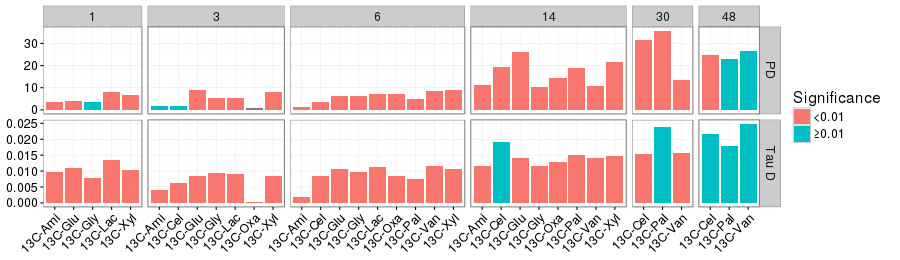

In [902]:
%%R -w 900 -h 260
df.bySubDay = df.all %>%
    filter((!is.na(Day) & !is.na(Substrate)))


p.bySubDay = ggplot(df.bySubDay, aes(Substrate, value, fill=Significance)) +
    geom_bar(stat='identity', position='dodge') +
    facet_grid(stat ~ Day, scales='free', space='free_x') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
        axis.title.x = element_blank(),
        axis.title.y = element_blank()        
    )
p.bySubDay 

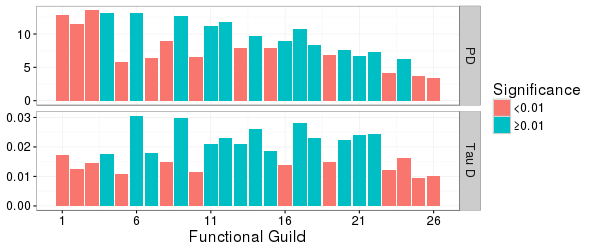

In [904]:
%%R -h 250 -w 600
df.byFG = df.all %>%
    filter(!is.na(FG))


p.byFG = ggplot(df.byFG, aes(FG, value, fill=Significance)) +
    geom_bar(stat='identity', position='dodge') +
    scale_x_continuous(breaks=seq(1,26,5)) +
    facet_grid(stat ~ ., scales='free_y') +
    labs(x='Functional Guild') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.y = element_blank()
    )
p.byFG 

### Combined plot figure

In [905]:
%%R
g_legend<-function(a.gplot){ 
  tmp <- ggplot_gtable(ggplot_build(a.gplot)) 
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box") 
  legend <- tmp$grobs[[leg]] 
  return(legend)} 

p.leg <- g_legend(p.byFG)
p.leg

TableGrob (3 x 3) "guide-box": 1 grobs
                                    z     cells   name           grob
99_bd09cd82f3a708fde529442a55887b18 1 (2-2,2-2) guides gtable[layout]


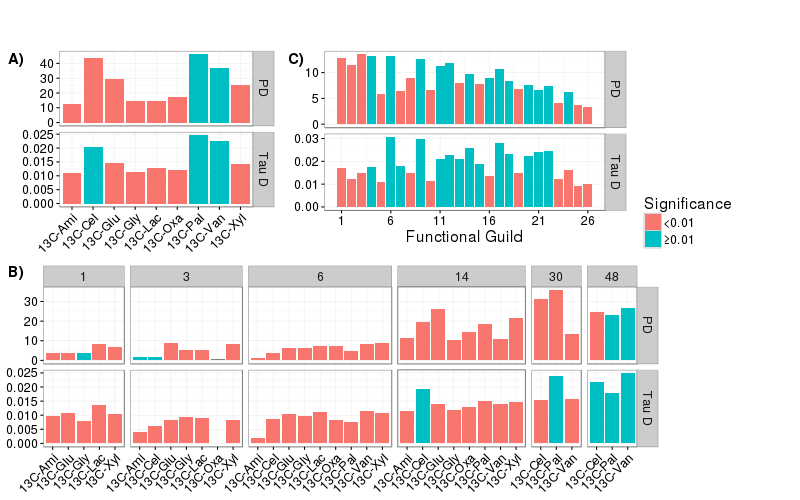

In [914]:
%%R -w 800 -h 500

p.bySub.t = p.bySub + theme(legend.position='none', axis.title.x = element_blank())
p.byFG.t = p.byFG + theme(legend.position='none')
p.bySubDay.t = p.bySubDay + theme(legend.position='none', axis.title.x = element_blank())
ggdraw() +
    draw_plot(p.bySub.t, 0.02,   0.48, 0.33, 0.43) +
    draw_plot(p.byFG.t, 0.36, 0.50, 0.43, 0.41) +
    draw_plot(p.leg, 0.76, 0.28, 0.2, 0.55) +    
    draw_plot(p.bySubDay.t, 0, 0, 0.83, 0.48) +
    draw_plot_label(c("A)", "B)", "C)"), c(0, 0, 0.35), c(0.905, 0.48, 0.905), size = 15)